In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../scripts')
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from keras.models import Model
import pandas as pd
import numpy as np
import AutoEncoderModel as aem
import matplotlib.pyplot as plt
from matplotlib import gridspec as grs
%matplotlib inline
import MyPlot as mp
from keras.models import model_from_json
from sklearn.decomposition import PCA
from keras.layers import  LSTM, GRU, Input

fit = aem.ModelFitting()

Using TensorFlow backend.


In [2]:
train_lcs_dir = '../../../Select_qso/lcs_qso_train/'
valid_lcs_dir = '../../../Select_qso/lcs_qso_valid/'
json_path = './keras_logs/model.json'
train_log_file = './keras_logs/181016/training.csv'
fit.catalog = '../../../../Catalogs/CRTS_QSO_catalog_final.csv'
fit.weights_path = './keras_logs/181016/weights.10000-4.312.h5'
fit.pred_length = 0.

In [3]:
json_string = open(json_path).read()
model = model_from_json(json_string)
model = fit.load_weights(model)
train_log = pd.read_csv(train_log_file)
redchisq = np.load('RedChiSq_tent.npz')

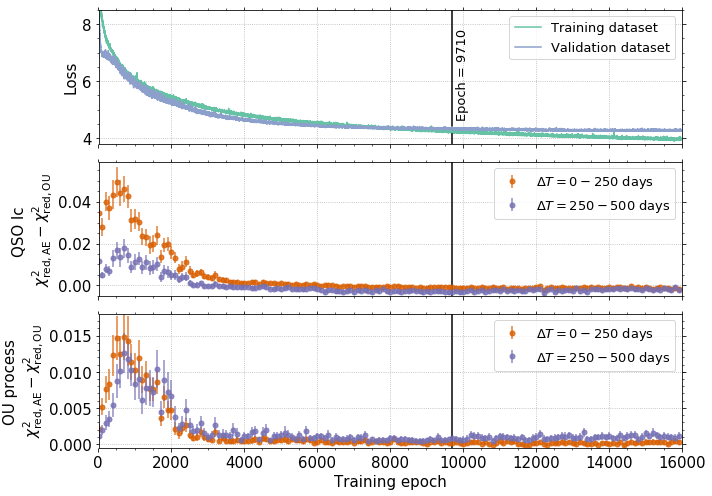

In [4]:
xlims = [10, 16000]
gs = grs.GridSpec(3, 1, height_ratios=(1,1,1))
plt.figure(figsize=(10, 7))
plt.subplots_adjust(hspace=0.025)
ax = []
loc= 9710
for ind in range(3):
    ax.append(plt.subplot(gs[ind]))
    
ax[0].tick_params(which="both", top=True, right=True, labelsize = 15, labelbottom="off", labeltop='off')
ax[0].grid(ls='dotted', zorder=2)
ax[0].minorticks_on()
ax[0].errorbar(train_log.epoch, train_log.loss, 
               color='#66c2a5', label='Training dataset')
ax[0].errorbar(train_log.epoch, train_log.val_loss, 
               color='#8da0cb', label='Validation dataset')
ax[0].vlines(loc, -10, 10)
ax[0].text(loc*1.01, 7.5, 'Epoch = %i'%loc , rotation=90, fontsize=13)
#ax[0].set_xscale('log')
ax[0].set_xlim(xlims); ax[0].set_ylim(3.8, 8.5)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend(loc='upper right', fontsize=13)

ax[1].tick_params(which="both", top=True, right=True, labelsize = 15, labelbottom="off", labeltop='off')
ax[1].grid(ls='dotted', zorder=2)
ax[1].minorticks_on()
ax[1].errorbar(redchisq['w_epochs'], redchisq['qso_mean'][:,7], yerr=redchisq['qso_std'][:,7], 
             fmt='.', color='#d95f02', alpha=0.8, label=r'$\Delta T = 0 - 250$ days', ms=10)
ax[1].errorbar(redchisq['w_epochs'], redchisq['qso_mean'][:,8], yerr=redchisq['qso_std'][:,8], 
             fmt='.', color='#7570b3', alpha=0.8, label=r'$\Delta T = 250 - 500$ days', ms=10)
ax[1].vlines(loc, -10, 10)
#ax[1].set_xscale('log')
ax[1].set_xlim(xlims); ax[1].set_ylim(-0.005, 0.059)
ax[1].set_ylabel(r"""QSO lc 
$\chi_{\mathrm{red, AE}}^2 - \chi_{\mathrm{red, OU}}^2$""", fontsize=15)
ax[1].legend(loc='upper right', fontsize=13)


ax[2].tick_params(which="both", top=True, right=True, labelsize = 15)
ax[2].grid(ls='dotted', zorder=2)
ax[2].minorticks_on()
ax[2].errorbar(redchisq['w_epochs'], redchisq['OU_mean'][:,7], yerr=redchisq['OU_std'][:,7], 
             fmt='.', color='#d95f02', alpha=0.8, label=r'$\Delta T = 0 - 250$ days', ms=10)
ax[2].errorbar(redchisq['w_epochs'], redchisq['OU_mean'][:,8], yerr=redchisq['OU_std'][:,8],
             fmt='.', color='#7570b3', alpha=0.8, label=r'$\Delta T = 250 - 500$ days', ms=10)
ax[2].vlines(loc, -10, 10)
#ax[2].set_xscale('log')
ax[2].set_xlim(xlims); ax[2].set_ylim(-0.0005, 0.018)
ax[2].set_xlabel('Training epoch', fontsize=15)
ax[2].set_ylabel(r"""OU process
$\chi_{\mathrm{red, AE}}^2 - \chi_{\mathrm{red, OU}}^2$""", fontsize=15)
ax[2].legend(loc='upper right', fontsize=13)

plt.tight_layout()
plt.savefig('Loss_epoch.pdf')
plt.show()


In [36]:
X_train, train_list = fit.load_lcs(train_lcs_dir)
X_valid, valid_list = fit.load_lcs(valid_lcs_dir)

Loading 12350 data:
Finish.
Loading 3088 data:
Finish.


In [37]:
file_list = np.r_[train_list, valid_list]

In [38]:
X_train_t = fit.split_lcs(X_train)
X_valid_t = fit.split_lcs(X_valid)
X_train_pad = fit.padding(X_train)
X_train_t_pad = fit.padding(X_train_t)
X_valid_pad = fit.padding(X_valid)
X_valid_t_pad = fit.padding(X_valid_t)

X_t, X_t_t, means_t, scales_t, errors_t, errors_t_t, wrong_units_t, wrong_units_t_t = \
    fit.preprocessing(X_train_pad, X_train_t_pad)
X_v, X_v_t, means_v, scales_v, errors_v, errors_v_t, wrong_units_v, wrong_units_v_t = \
    fit.preprocessing(X_valid_pad, X_valid_t_pad)
    
X_t[np.isnan(X_t)] = 0.
X_v[np.isnan(X_v)] = 0.
X_t_t[np.isnan(X_t_t)] = 0.
X_v_t[np.isnan(X_v_t)] = 0.

#redshift_t_arr = fit.load_redshifts(train_list)
#redshift_v_arr = fit.load_redshifts(valid_list)

#redshift_t_arr = fit.load_redshifts(train_list)
#redshift_v_arr = fit.load_redshifts(valid_list)

#X_t = fit.intrinsic_time(X_t, redshift_t_arr)
#X_v = fit.intrinsic_time(X_v, redshift_v_arr)
#X_t_t = fit.intrinsic_time(X_t_t, redshift_t_arr)
#X_v_t = fit.intrinsic_time(X_v, redshift_v_arr)

#X_t[:,:,2] *= scales_t
#X_v[:,:,2] *= scales_v
#X_t_t[:,:,2] *= scales_t
#X_v_t[:,:,2] *= scales_v

In [39]:
X = np.r_[X_t, X_v]
X_t = np.r_[X_t_t, X_v_t]

In [40]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X[:,::-1], 'aux_input': np.delete(X, [1,2], axis=2)})
decoding = decode_model.predict({'main_input': X[:,::-1], 'aux_input': np.delete(X, [1,2], axis=2)})

(18.27246846102901, 17.459941730222326)

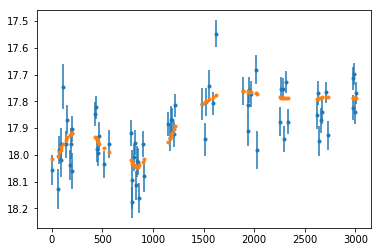

In [43]:
i = 0
plt.errorbar(X_train[i][:,0], X_train[i][:,1], yerr=X_train[i][:,2], fmt='.')
plt.errorbar(X_train[i][:,0], decoding[i][:len(X_train[i][:,0])]*scales_t[i]+means_t[i],fmt='.')
plt.ylim(plt.ylim()[::-1])

(0.0, 1.0)

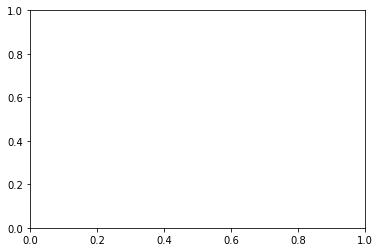

In [623]:
plt.xlim()[0], plt.ylim()[1]

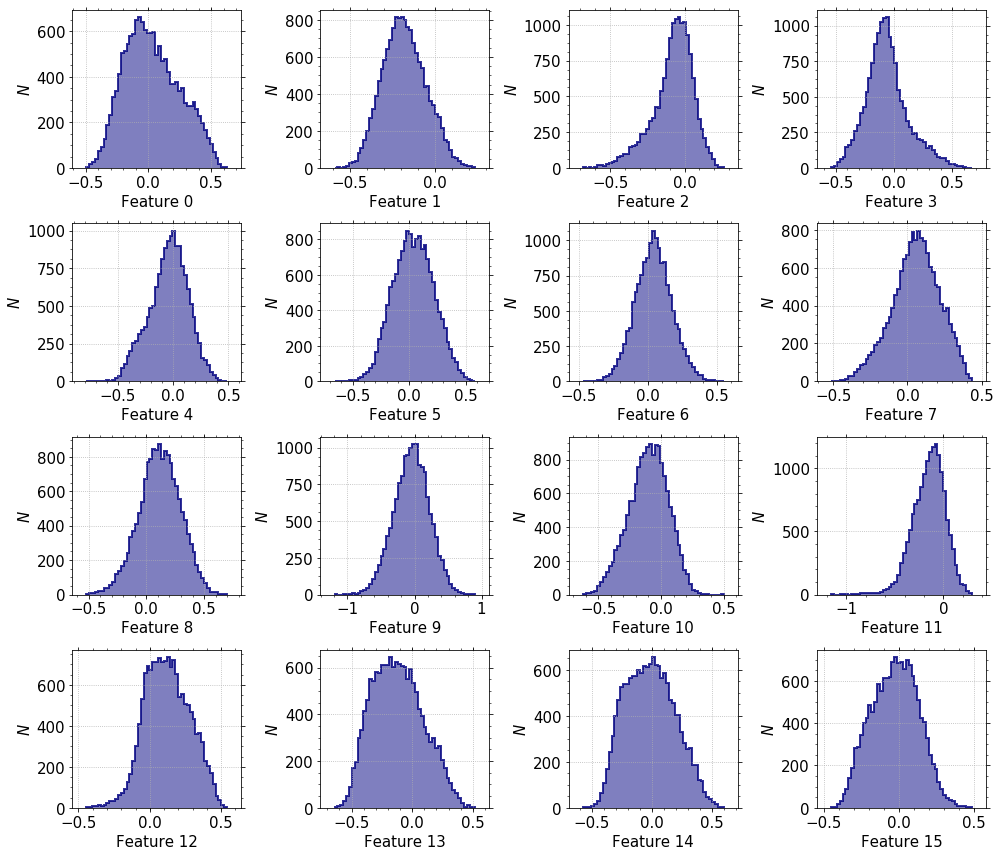

In [630]:
plt.figure(figsize=(14, 12))
for i in np.arange(0, 16, 1):
    plt.subplot(4, 4, i+1)
    feat_num = i
    feat = np.array(encoding[:,feat_num], dtype='float')
    xlim = [np.min(feat), np.max(feat)]
    mp.hist(np.array(feat, dtype='float'), color='navy', xlims=xlim)
    plt.xlabel('Feature %d'%feat_num)
    #plt.legend('upper left', fontsize=13, frameon=False)
plt.tight_layout()
plt.savefig('Features_hist.pdf')
plt.show()

In [46]:
pca  = PCA(n_components=2).fit_transform(encoding)

In [5]:
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from scipy import stats

def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 200, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [48]:
rx,  ry, rz  =  kde_contour_dat(pca[:, 0], pca[:, 1], grid_bins=100, extent=[-1, 1, -1, 1])
X_pca, Y_pca = pca[:, 0], pca[:, 1]

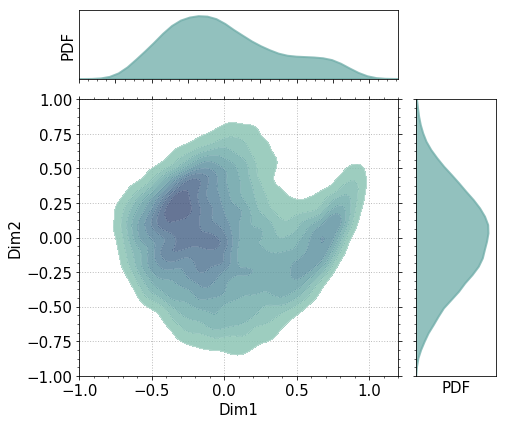

In [628]:
xlims = [-1, 1.2]
ylims = [-1, 1]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(7, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X_pca)
kde_Y = stats.gaussian_kde(Y_pca)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Features_valid_PCA.pdf', pad_inches=0.5)
plt.show()

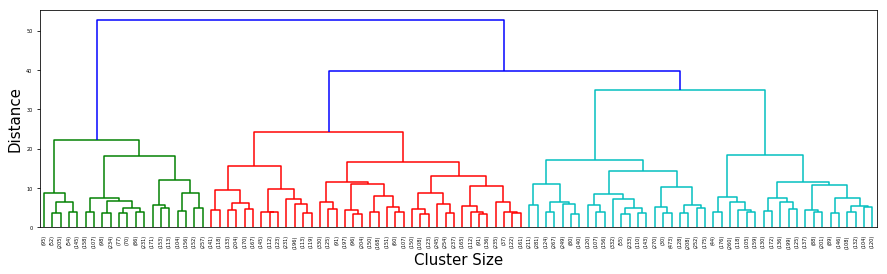

In [51]:
from  scipy.cluster.hierarchy  import linkage, dendrogram, fcluster
Catalina_linkage_result = linkage(encoding, method='ward', metric='euclidean')

threshold = 0.75 * np.max(Catalina_linkage_result[:, 2])
plt.figure(num=None, figsize=(15, 4), facecolor='w', edgecolor='k')
dendrogram(Catalina_linkage_result, color_threshold=threshold, truncate_mode='lastp', p=100)
plt.tick_params(labelsize = 5)
plt.xlabel('Cluster Size', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.show()

Catalina_clustered = fcluster(Catalina_linkage_result, threshold, criterion='distance')

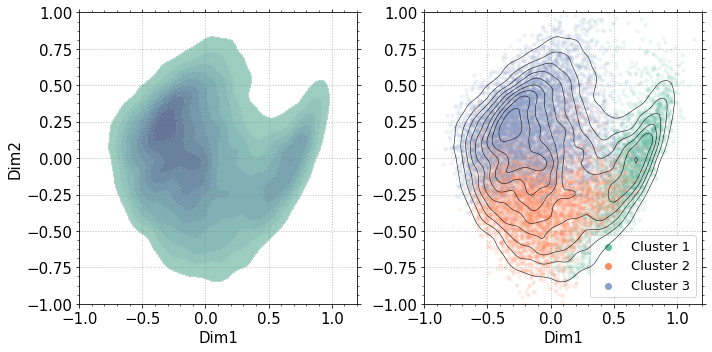

In [54]:
col_dict=['#66c2a5', 
'#fc8d62', 
'#8da0cb']

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)

plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
CS = plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)

plt.subplot(1,2,2)
plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("black",), alpha = 1, zorder = 11)
for cl in range(1, np.max(Catalina_clustered)+1):
    label = 'Cluster ' + str(cl)
    plt.scatter(pca[:, 0][Catalina_clustered==cl], 
                  pca[:, 1][Catalina_clustered==cl], alpha=0.1, 
                  s=10, color=col_dict[cl-1])
    plt.scatter(-100, -100,  label = label, color=col_dict[cl-1])
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
#plt.ylabel('Dim2', fontsize=15)
plt.legend(fontsize=13)
plt.tight_layout()
#plt.savefig(log_dir+'/Catalina_Clustered.pdf', pad_inches=0.5)


In [55]:
CRTS_id = np.empty(len(file_list))
for i, fname in enumerate(file_list):
    CRTS_id[i] = fname.split('.')[0]
CRTS_id = np.array(CRTS_id, dtype=int)
cluster_df = pd.DataFrame({'CRTS_id': CRTS_id, 'Cluster': Catalina_clustered, 'PCA1': pca[:,0], 'PCA2': pca[:,1]})
cluster_df = pd.concat([cluster_df, pd.DataFrame(encoding)], axis=1)

In [58]:
mean_feat_cluster1 = np.median(cluster_df[np.arange(0,16,dtype='int')][cluster_df.Cluster==1], axis=0)
mean_feat_cluster2 = np.median(cluster_df[np.arange(0,16,dtype='int')][cluster_df.Cluster==2], axis=0)
mean_feat_cluster3 = np.median(cluster_df[np.arange(0,16,dtype='int')][cluster_df.Cluster==3], axis=0)
mean_feat_all = np.mean(encoding, axis=0)

In [59]:
cat = pd.read_csv(fit.catalog)
cat_cluster = pd.merge(cat, cluster_df, on='CRTS_id')

In [60]:
cluster1 = cat_cluster.Cluster==1
cluster2 = cat_cluster.Cluster==2
cluster3 = cat_cluster.Cluster==3

In [61]:
model_input_decoder = Input(shape=(X.shape[1], encoding.shape[1]+1), name='decoder_input')

# taking the decoder out -> generator 
for i in np.arange(-3, 0):
    if i == -3:
        deco = model.layers[i](model_input_decoder)
    else: 
        deco= model.layers[i](deco)
        
generator = Model(model_input_decoder, deco)

In [62]:
_model = Model(input=model.input, output=model.layers[-4].get_output_at(0))
_values = _model.predict({'main_input': X[:,::-1], 'aux_input': np.delete(X, [1,2], axis=2)})

In [64]:
X_model = np.r_[X_train, X_valid]
scales = np.r_[scales_t, scales_v]
means = np.r_[means_t, means_v]
#redshift = np.r_[redshift_t_arr, redshift_v_arr]

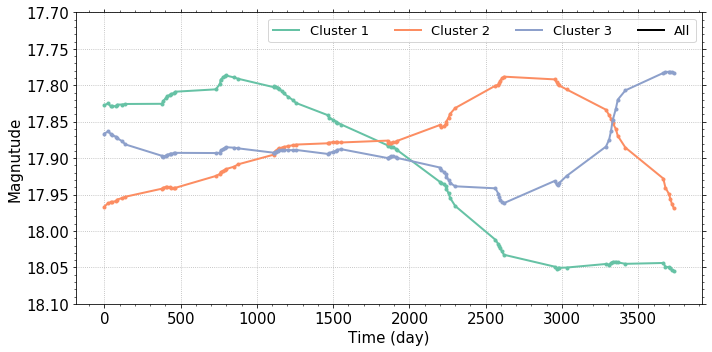

In [84]:
plt.figure(figsize=(10, 5))

ind_rand = np.random.choice(np.where(cat_cluster.Cluster==1)[0], 1)
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(mean_feat_cluster1):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0], 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color=col_dict[0], label=None, linewidth=2, alpha=1)

#ind_rand = np.random.choice(np.where(cat_cluster.Cluster==2)[0], 1)
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(mean_feat_cluster2):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0], 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color=col_dict[1], label=None, linewidth=2, alpha=1)
    
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(mean_feat_cluster3):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0], 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color=col_dict[2], label=None, linewidth=2, alpha=1)

#ind_rand = np.random.choice(np.where(cluster.Cluster!=np.nan)[0], 1000)
#for ind in ind_rand:
#    inp = _values[ind][np.newaxis, :, :]
#    for i, val in enumerate(mean_feat_all):
#        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
#    plt.errorbar(X_model[ind][:,0], 
#                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
#                 fmt='.-', color='k', label=None, linewidth=2, alpha=1)

plt.errorbar(0,0, fmt='-', color=col_dict[0], label='Cluster 1', linewidth=2, alpha=1) 
plt.errorbar(0,0, fmt='-', color=col_dict[1], label='Cluster 2', linewidth=2, alpha=1) 
plt.errorbar(0,0, fmt='-', color=col_dict[2], label='Cluster 3', linewidth=2, alpha=1) 
#plt.errorbar(0,0, fmt='-', color=col_dict[3], label='Cluster 4', linewidth=2, alpha=1) 
plt.errorbar(0,0, fmt='-', color='k', label='All', linewidth=2, alpha=1) 

plt.xlabel('Time (day)', fontsize=15)
plt.ylabel('Magnutude', fontsize=15)
plt.ylim(18.1, 17.7)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.grid(ls='dotted', zorder=2)
plt.minorticks_on()
plt.legend(fontsize=13, loc='best', ncol=4)
plt.tight_layout()

In [184]:
cluster2_cent = (pca[:,0] - 2.25)**2 + (pca[:,1] - 0.5)**2 < 0.5
cluster1_cent = (pca[:,0] + 2.25)**2 + (pca[:,1] + 0.25)**2 < 0.5
cent = (pca[:,0] - 0. )**2 + (pca[:,1] - 0.)**2 < 0.75

In [185]:
cent_feat_cluster1 = np.mean(cluster_df[np.arange(0,32,dtype='int')][cluster1_cent], axis=0)
cent_feat_cluster2 = np.mean(cluster_df[np.arange(0,32,dtype='int')][cluster2_cent], axis=0)
cent_feat = np.mean(cluster_df[np.arange(0,32,dtype='int')][cent], axis=0)

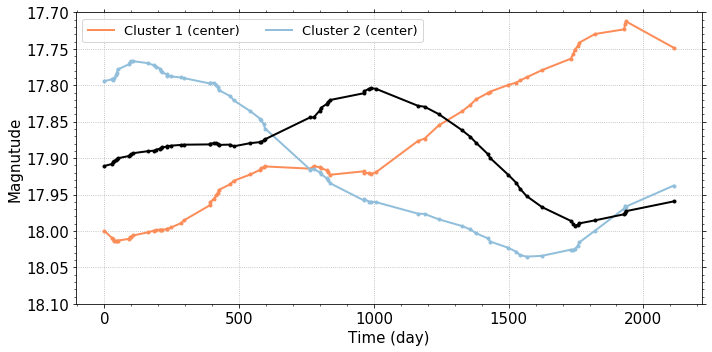

In [377]:
plt.figure(figsize=(10, 5))

#ind_rand = np.random.choice(np.where(cat_cluster.Cluster==1)[0], 1)
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(cent_feat_cluster1):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0]/(1+redshift[ind]), 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color=col_dict[0], label=None, linewidth=2, alpha=1)

#ind_rand = np.random.choice(np.where(cat_cluster.Cluster==2)[0], 1)
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(cent_feat_cluster2):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0]/(1+redshift[ind]), 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color=col_dict[1], label=None, linewidth=2, alpha=1)

#ind_rand = np.random.choice(np.where(cluster.Cluster!=np.nan)[0], 1000)
for ind in ind_rand:
    inp = _values[ind][np.newaxis, :, :]
    for i, val in enumerate(cent_feat):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    plt.errorbar(X_model[ind][:,0]/(1+redshift[ind]), 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0]+means[0],
                 fmt='.-', color='k', label=None, linewidth=2, alpha=1)

plt.errorbar(0,0, fmt='-', color=col_dict[0], label='Cluster 1 (center)', linewidth=2, alpha=1) 
plt.errorbar(0,0, fmt='-', color=col_dict[1], label='Cluster 2 (center)', linewidth=2, alpha=1) 
#plt.errorbar(0,0, fmt='-', color=col_dict[2], label='Cluster 3', linewidth=2, alpha=1) 
#plt.errorbar(0,0, fmt='-', color=col_dict[3], label='Cluster 4', linewidth=2, alpha=1) 
#plt.errorbar(0,0, fmt='-', color='k', label='All', linewidth=2, alpha=1) 

plt.xlabel('Time (day)', fontsize=15)
plt.ylabel('Magnutude', fontsize=15)
plt.ylim(18.1, 17.7)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.grid(ls='dotted', zorder=2)
plt.minorticks_on()
plt.legend(fontsize=13, loc='best', ncol=4)
plt.tight_layout()

In [376]:
ind 

5164

Text(0,0.5,'Dim2')

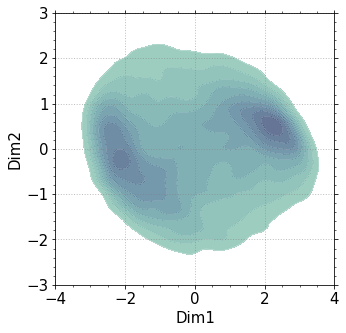

In [380]:
col_dict=['#fc8d59', '#91bfdb']
xlims = [-4, 4]
ylims = [-3, 3]

plt.figure(figsize=(5, 5))

plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
CS = plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)

In [85]:
sep_num = 5
x_lims = np.array(np.percentile(pca[:,0], [0.5, 99.5]))
y_lims = np.array(np.percentile(pca[:,1], [0.5, 99.5]))
x_grid = np.linspace(x_lims[0], x_lims[1], sep_num+1)
y_grid = np.linspace(y_lims[1], y_lims[0], sep_num+1)

bound_list = np.empty((sep_num**2, 2, 2))
i = 0
for y1, y2 in zip(y_grid[:-1], y_grid[1:]):
    for x1, x2 in zip(x_grid[:-1], x_grid[1:]):
        bound_list[i] = np.array([[x1, x2], [y1, y2]]) 
        i += 1
    
cell_center = np.empty((sep_num**2, 2))
for i, bl in enumerate(bound_list):
    cell_center[i,:] = np.array([np.mean(bl[0]), np.mean(bl[1])])

In [86]:
num_label = [chr(i) for i in np.arange(65, 65+len(cell_center), 1)]

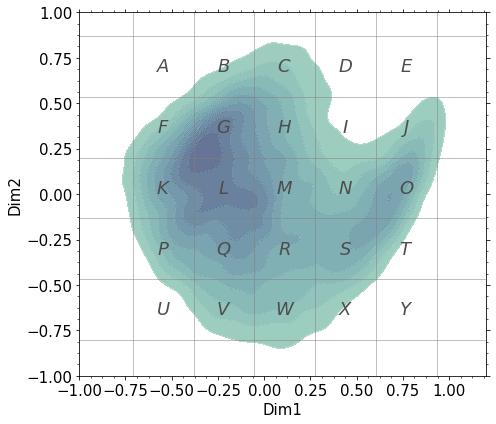

In [631]:
xlims = [-1, 1.2]
ylims = [-1, 1]

plt.figure(figsize=(7, 6))

#plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 1)
plt.vlines(x_grid, -10, 10, color='grey', lw=0.5)
plt.hlines(y_grid, -10, 10, color='grey', lw=0.5)

for i, num in enumerate(num_label):
    plt.text(cell_center[:,0][i], cell_center[:,1][i], r'$\mathit{%s}$'%num, 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=18, color='0.3')


plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)
plt.tight_layout()
plt.savefig('Features_valid_pca_grid.pdf')

In [89]:
cell = np.empty(len(pca))
for i, (x, y) in enumerate(bound_list):
    mask = (x[0] <= pca[:,0]) & (pca[:,0] < x[1]) & (y[1] <= pca[:,1]) & (pca[:,1] < y[0])
    cell[mask] = i

In [96]:
feats_cell = np.mean(cluster_df[np.arange(0,16,dtype='int')][cell==24].values, axis=0)
feats_cell

array([ 0.23757663, -0.1182649 , -0.41482085,  0.33618844, -0.14584942,
       -0.19176403,  0.08625171, -0.26107866,  0.2605936 ,  0.38386393,
       -0.05284005, -0.25198156,  0.1505397 ,  0.28143775,  0.26583025,
        0.03189692], dtype=float32)

In [100]:
feats_cell_list = np.empty((sep_num**2, len(encoding[0])))
for i in range(len(cell_center)):
    feats_cell_list[i, :] = np.mean(cluster_df[np.arange(0, len(encoding[0]), dtype='int')][cell==i].values, axis=0)

In [101]:
import scipy as sp
import scipy.interpolate

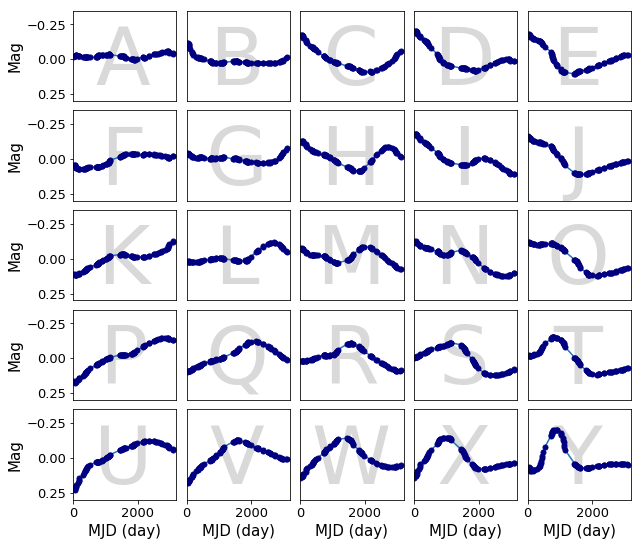

In [118]:
ind = 5163
inp = _values[ind][np.newaxis, :, :]
ylims = np.array([0.3, -0.35])
xlims= np.array([0, 3200])

new_length = 500
new_x = np.linspace(X_model[ind][0,0], X_model[ind][-1,0], new_length)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for j, feats in enumerate(feats_cell_list):
    plt.subplot(5,5,j+1)
    plt.tick_params(which="both", top=False, right=False, bottom=False, left=False, 
                    labelbottom="off", labelleft="off", labelsize=13)
    if j>=(sep_num**2 - sep_num):
        plt.xlabel('MJD (day)', fontsize=15)
        plt.tick_params(bottom=True, labelbottom='on')
        plt.minorticks_on()
    if j%sep_num==0:
        plt.ylabel('Mag', fontsize=15)
        plt.tick_params(left=True, labelleft='on')
        plt.minorticks_on()
        
    for i, val in enumerate(feats):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    new_y = sp.interpolate.interp1d(X_model[ind][:,0], 
                                    np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0], #+means[0],
                                    kind='linear', assume_sorted=True)(new_x)
    plt.errorbar(X_model[ind][:,0], #/(1+redshift[ind]), 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0], #+means[0],
                 fmt='.', color='navy', label=None,markersize=10,  alpha=1, zorder=2)
    plt.plot(new_x, new_y)
    plt.text(np.mean(plt.xlim()), np.mean(ylims)+0.05, num_label[j], 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=80, color='k', zorder=1, alpha=0.15)
    #print(j)
    plt.xlim(xlims); plt.ylim(ylims)
plt.tight_layout()
plt.savefig('lcs_valid_pca_grid.pdf')
plt.show()

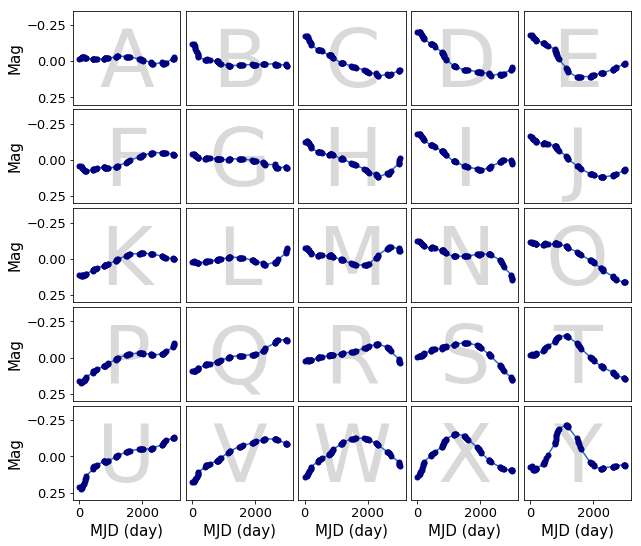

In [635]:
ind = 0
inp = _values[ind][np.newaxis, :, :]
ylims = np.array([0.3, -0.35])
xlims= np.array([-200, 3200])

new_length = 500
new_x = np.linspace(X_model[ind][0,0], X_model[ind][-1,0], new_length)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for j, feats in enumerate(feats_cell_list):
    plt.subplot(5,5,j+1)
    plt.tick_params(which="both", top=False, right=False, bottom=False, left=False, 
                    labelbottom="off", labelleft="off", labelsize=13)
    if j>=(sep_num**2 - sep_num):
        plt.xlabel('MJD (day)', fontsize=15)
        plt.tick_params(bottom=True, labelbottom='on')
        plt.minorticks_on()
    if j%sep_num==0:
        plt.ylabel('Mag', fontsize=15)
        plt.tick_params(left=True, labelleft='on')
        plt.minorticks_on()
        
    for i, val in enumerate(feats):
        inp[0][:,i+1] = val*np.ones_like(inp[0][:,i+1])
    new_y = sp.interpolate.interp1d(X_model[ind][:,0], 
                                    np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0], #+means[0],
                                    kind='linear', assume_sorted=True)(new_x)
    plt.errorbar(X_model[ind][:,0], #/(1+redshift[ind]), 
                 np.squeeze(generator.predict(inp))[0:len(X_model[ind][:,0])]*scales[0], #+means[0],
                 fmt='.', color='navy', label=None,markersize=10,  alpha=1, zorder=2)
    plt.plot(new_x, new_y)
    plt.text(np.mean(plt.xlim()), np.mean(ylims)+0.05, num_label[j], 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=80, color='k', zorder=1, alpha=0.15)
    #print(j)
    plt.xlim(xlims); plt.ylim(ylims)
#plt.tight_layout()
plt.savefig('lcs_valid_pca_grid.pdf')
plt.show()

In [130]:
def hist_cluster(val, xlims, label, loc='best', legend=True):
    
    mp.hist(val, 
        xlims=xlims,alpha=0.3, ealpha=0.7, 
        color='grey', legend = 'All')
    mp.hist(val[Catalina_clustered==1],
        xlims=xlims, alpha=0.3, ealpha=0.7, 
        color=col_dict[0], legend = 'Cluster1')
    mp.hist(val[Catalina_clustered==2], label=label, 
        xlims=xlims, alpha=0.3, ealpha=0.7, 
        color=col_dict[1], legend = 'Cluster2')
    
    
    if legend:
        plt.legend(fontsize=13, loc=loc)
    plt.tight_layout()

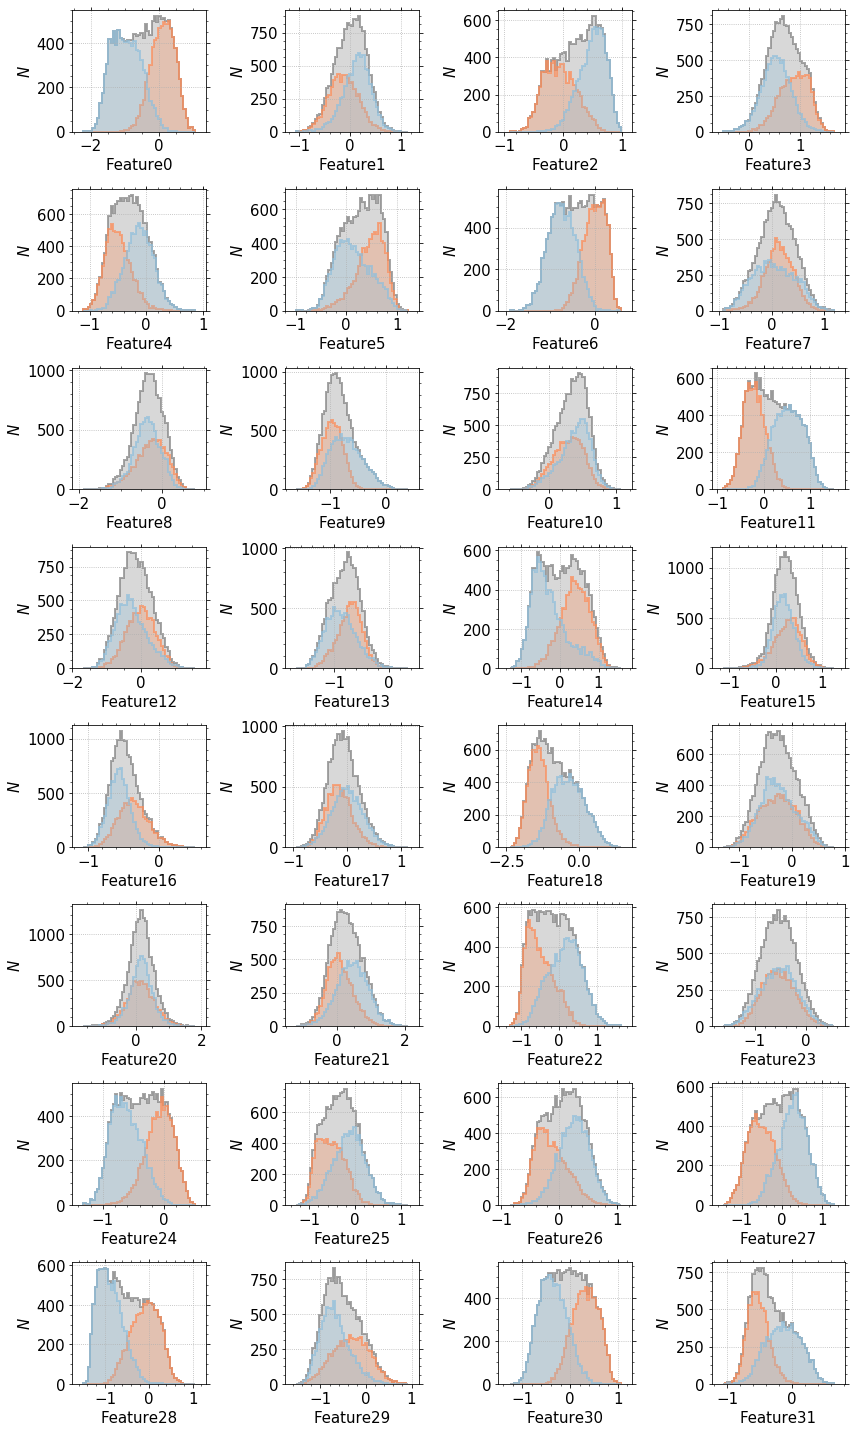

In [619]:
plt.figure(figsize=(12, 20))
for i in np.arange(0, 32, 1):
    feat = encoding[:,i]
    plt.subplot(8, 4, i+1)
    hist_cluster(feat, [np.min(feat), np.max(feat)], "Feature%d"%i, legend=False)
#plt.savefig('tent3.pdf')
plt.show()

In [107]:
import itertools
import numpy as np

def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m # 補間式（係数）

# 補間式（係数）から 各格子点のz値を算出
def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

def inpolygon(sx, sy, x, y):
    ''' 
    x[:], y[:]: polygon
    sx, sy: point
    '''     
    np = len(x)
    inside = False
    for i1 in range(np): 
        i2 = (i1+1)%np
        if min(x[i1], x[i2]) < sx < max(x[i1], x[i2]):
            #a = (y[i2]-y[i1])/(x[i2]-x[i1])
            #b = y[i1] - a*x[i1]
            #dy = a*sx+b - sy
            #if dy >= 0:
            if (y[i1] + (y[i2]-y[i1])/(x[i2]-x[i1])*(sx-x[i1]) - sy) > 0:
                inside = not inside

    return inside

from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['#2c7fb8', '#a6bddb', '#ece2f0'])

dat0= CS.allsegs[0][0] 
mbh_mask = (~np.isnan(cat_cluster.LOGBH)) & (cat_cluster.LOGBH!=0) & (cat_cluster.EddLumRatio<=1)

In [108]:
cat_slope = pd.read_csv('../../../../Catalogs/CRTS_QSO_catalog_slope.csv')

In [109]:
cat_cluster_slope = pd.merge(cat_slope, cluster_df, on='CRTS_id')

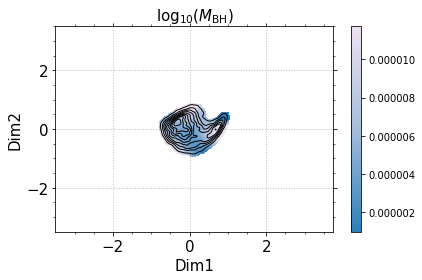

In [111]:
z = cat_cluster_slope.slope[mbh_mask].values

z_99 = np.percentile(z, [0.05, 99.95])
z_mask = np.where((z_99[0] < z) & (z < z_99[1]))
z = z[z_mask[0]]
x = pca[:,0][mbh_mask][z_mask[0]]
y = pca[:,1][mbh_mask][z_mask[0]]

#clims = np.percentile(z, [45, 55])
clims = np.average(z) + np.array([-np.std(z), +np.std(z)])*0.1

# n(3)次多項式での補間式（係数）を算出
N_ORDER = 2
m = polyfit2d(x,y,z,N_ORDER)

N_MESH = 200
xx, yy = np.meshgrid( np.linspace(np.min(x), np.max(x), N_MESH),
                      np.linspace(np.min(y), np.max(y), N_MESH))
zz = polyval2d(xx, yy, m)

inside = np.ndarray(len(xx.flatten()), dtype=bool)
inside[:] = False
for i, (sx, sy) in enumerate(zip(xx.flatten(), yy.flatten())):
    inside[i] = inpolygon(sx, sy, dat0[:,0], dat0[:,1])

plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
#plt.contourf(rx, ry, rz, levels = levels,
#             origin = origin,
#             cmap = cmap, alpha = 0.8)
CS = plt.contour(rx, ry, rz, levels = levels,
                    linewidths=1, origin = origin,
                    colors = ("k",), alpha = 1, zorder = 11)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)
plt.title(r'$\log_{10}(M_{\mathrm{BH}})$', fontsize=15)
plt.scatter(xx.flatten()[inside],yy.flatten()[inside],c=zz.flatten()[inside], alpha=1, marker='s', s=10, cmap=cm)
plt.clim(clims)
#plt.clim(0.11, 0.12)
plt.xlim(-3.5, 3.75)
plt.ylim(-3.5, 3.5)
plt.colorbar()
plt.tight_layout()
plt.show()

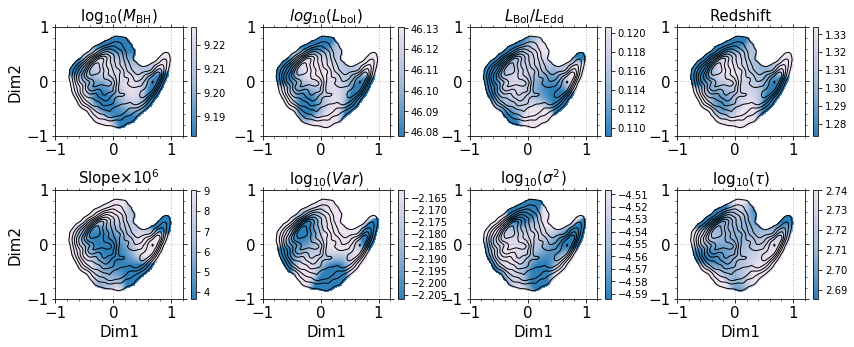

In [641]:
val_list = [cat_cluster.LOGBH[mbh_mask].values, 
           np.log10(cat_cluster.Bol_Lum[mbh_mask].values), 
           cat_cluster.EddLumRatio[mbh_mask].values, 
           cat_cluster.redshift[mbh_mask].values, 
           cat_cluster_slope.slope[mbh_mask].values*1e6, 
           np.log10(cat_cluster.Variance[mbh_mask].values), 
           np.log10(np.abs(cat_cluster.sigma[mbh_mask].values**2)), 
           np.log10(cat_cluster.tau[mbh_mask].values)]

title_list = ['$\log_{10}(M_{\mathrm{BH}})$', '$log_{10}(L_{\mathrm{bol}})$', 
             '$L_{\mathrm{Bol}}/L_{\mathrm{Edd}}$', 'Redshift', 
             r'Slope$\times 10^6$', '$\log_{10}(Var)$', 
             '$\log_{10}(\sigma^2)$', r'$\log_{10}(\tau)$']

plt.figure(figsize=(14, 5))
xlims = [-1, 1.2]
ylims = [-1, 1]
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for i, (z, name) in enumerate(zip(val_list, title_list)):
    plt.subplot(2,4,i+1)
    
    z_99 = np.percentile(z, [0.05, 99.95])
    z_mask = np.where((z_99[0] < z) & (z < z_99[1]))
    z = z[z_mask[0]]
    x = pca[:,0][mbh_mask][z_mask[0]]
    y = pca[:,1][mbh_mask][z_mask[0]]

    #clims = np.percentile(z, [45, 55])
    clims = np.average(z) + np.array([-np.std(z), +np.std(z)])*0.05

    # n(3)次多項式での補間式（係数）を算出
    N_ORDER = 3
    m = polyfit2d(x,y,z,N_ORDER)

    N_MESH = 200
    xx, yy = np.meshgrid( np.linspace(np.min(x), np.max(x), N_MESH),
                          np.linspace(np.min(y), np.max(y), N_MESH))
    zz = polyval2d(xx, yy, m)

    plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
    plt.tick_params(which="both", top=True, right=True)
    plt.minorticks_on()
    #plt.contourf(rx, ry, rz, levels = levels,
    #             origin = origin,
    #             cmap = cmap, alpha = 0.8)
    CS = plt.contour(rx, ry, rz, levels = levels,
                        linewidths=1, origin = origin,
                        colors = ("k",), alpha = 1, zorder = 11)
    plt.xlim(xlims); plt.ylim(ylims)
    plt.tick_params(labelsize = 15)
    if i > 3:
        plt.xlabel('Dim1', fontsize=15)
    if i %4 ==0:
        plt.ylabel('Dim2', fontsize=15)
    plt.title(name, fontsize=15)
    plt.scatter(xx.flatten()[inside],yy.flatten()[inside],c=zz.flatten()[inside], alpha=1, marker='s', s=2, cmap=cm)
    plt.clim(clims)
    #plt.clim(0.11, 0.12)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.colorbar()
    
#plt.tight_layout()
plt.savefig('Params_pca_distribution.pdf')
plt.show()

In [253]:
from vorbin.voronoi_2d_binning import voronoi_2d_binning

In [291]:
def _display_pixels(x, y, counts, pixelsize):
    """
    Display pixels at coordinates (x, y) coloured with "counts".
    This routine is fast but not fully general as it assumes the spaxels
    are on a regular grid. This needs not be the case for Voronoi binning.

    """
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    nx = int(round((xmax - xmin)/pixelsize) + 1)
    ny = int(round((ymax - ymin)/pixelsize) + 1)
    img = np.full((nx, ny), np.nan)  # use nan for missing data
    j = np.round((x - xmin)/pixelsize).astype(int)
    k = np.round((y - ymin)/pixelsize).astype(int)
    img[j, k] = counts

    plt.imshow(np.rot90(img), interpolation='nearest', cmap=cm,
               extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                       ymin - pixelsize/2, ymax + pixelsize/2])
    plt.colorbar()

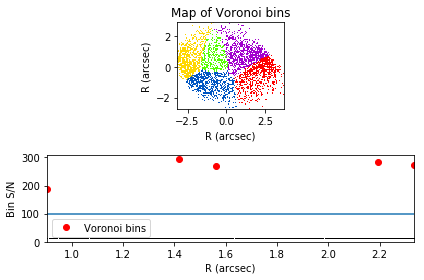

In [343]:
x  = cat_cluster.PCA1[mbh_mask].values; y = cat_cluster.PCA2[mbh_mask].values
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x,  y, 
    100.*np.ones(len(x)), 10.*np.ones(len(y)), 
    100,  plot=1, quiet=1, wvt=True, cvt=True, pixelsize=0.07)
plt.tight_layout()
plt.pause(1)

In [344]:
#binNum = cat_cluster.Cluster.values[mbh_mask]-1
LOGMBH_arr = np.empty(np.max(binNum)+1)
LOGMBH_err_arr = np.empty(np.max(binNum)+1)

z = cat_cluster.EddLumRatio[mbh_mask]
clims = np.average(z) + np.array([-np.std(z), +np.std(z)])*0.05
for i in range(np.max(binNum)+1):
    #val_i = np.log10(cat_cluster.Variance[mbh_mask][binNum==i])
    val_i = z[binNum==i]
    per99 = np.percentile(val_i, [0.25, 99.75])
    val_i = val_i[ (per99[0] <= val_i) & (val_i < per99[1] ) ]
    LOGMBH_arr[i] = np.average(val_i)
    LOGMBH_err_arr[i] = np.std(val_i)/np.sqrt(len(val_i))

In [345]:
test = np.empty(len(binNum))

for i, Bin in enumerate(binNum):
    test[i] = LOGMBH_arr[Bin]

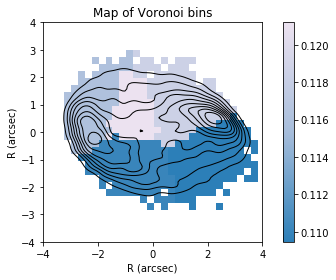

In [346]:
rnd = np.argsort(np.random.random(xNode.size))  # Randomize bin colors
_display_pixels(x, y, test, 0.25)
plt.clim(clims)
#plt.plot(xNode, yNode, '+w', scalex=False, scaley=False) # do not rescale after imshow()
plt.contour(rx, ry, rz, levels = levels,
                        linewidths=1, origin = origin,
                        colors = ("k",), alpha = 1, zorder = 11)
plt.xlabel('R (arcsec)')
plt.ylabel('R (arcsec)')
plt.title('Map of Voronoi bins')
plt.tight_layout()
plt.show()

In [192]:
feat_list = ['magnitude', 'redshift', 'Av_ct', 'Bol_Lum', 'sigma', 'tau', 'LOGBH', 'Variance', 'EddLumRatio']
feat_df = cat_cluster[feat_list]
feat_df.Bol_Lum = np.log10(feat_df.Bol_Lum)
feat_df.sigma = np.log10(feat_df.sigma**2)
feat_df.tau = np.log10(feat_df.tau)
feat_df.Variance = np.log10(feat_df.Variance)

In [245]:
cluster2_cent = (cat_cluster.PCA1 - 2.25)**2 + (cat_cluster.PCA2 - 0.25)**2 < 0.25
cluster1_cent = (cat_cluster.PCA1 + 2.25)**2 + (cat_cluster.PCA2 + 0.25)**2 < 0.25
cent = (cat_cluster.PCA1 - 0. )**2 + (cat_cluster.PCA2 - 0.)**2 < 0.25

In [246]:
np.average(feat_df.EddLumRatio[cluster1_cent&mbh_mask]), np.average(feat_df.EddLumRatio[cluster2_cent&mbh_mask]), np.average(feat_df.EddLumRatio[cent&mbh_mask])

(0.12741584836538639, 0.11581737477169474, 0.12376615678348227)

In [247]:

feats_mean = np.empty((len(feat_list),3))
feats_std = np.empty((len(feat_list),3))
for i, feat in enumerate(feat_list):
    feat_i = feat_df[feat][mbh_mask]
    per99 = np.percentile(feat_i, [2.5, 97.5])
    per99_mask = (per99[0] < feat_df[feat]) & ( feat_df[feat] < per99[1]) 
    mean_i = np.nanmean(feat_i[per99_mask])
    feats_mean[i,0] = np.nanmean(feat_df[feat][mbh_mask&cluster1_cent&per99_mask])/mean_i
    feats_mean[i,1] = np.nanmean(feat_df[feat][mbh_mask&cluster2_cent&per99_mask])/mean_i
    feats_mean[i,2] = np.nanmean(feat_df[feat][mbh_mask&cent&per99_mask])/mean_i
    feats_std[i,0] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cluster1_cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cluster1_cent&per99_mask])))/mean_i)
    feats_std[i,1] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cluster2_cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cluster2_cent&per99_mask])))/mean_i)
    feats_std[i,2] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cent&per99_mask])))/mean_i)

In [249]:
feats_mean = np.empty((len(feat_list),2))
feats_std = np.empty((len(feat_list),2))
for i, feat in enumerate(feat_list):
    feat_i = feat_df[feat][mbh_mask]
    per99 = np.percentile(feat_i, [0.05, 99.95])
    per99_mask = (per99[0] < feat_df[feat]) & ( feat_df[feat] < per99[1]) 
    mean_i = np.nanmean(feat_i[per99_mask])
    feats_mean[i,0] = np.nanmean(feat_df[feat][mbh_mask&cluster1&per99_mask])/mean_i
    feats_mean[i,1] = np.nanmean(feat_df[feat][mbh_mask&cluster2&per99_mask])/mean_i
    #feats_mean[i,2] = np.nanmean(feat_df[feat][mbh_mask&cent&per99_mask])/mean_i
    feats_std[i,0] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cluster1_cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cluster1&per99_mask])))/mean_i)
    feats_std[i,1] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cluster2_cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cluster2&per99_mask])))/mean_i)
    #feats_std[i,2] = np.abs(np.nanstd(feat_df[feat][mbh_mask&cent&per99_mask])/np.sqrt(np.sum(~np.isnan(feat_df[feat][mbh_mask&cent&per99_mask])))/mean_i)

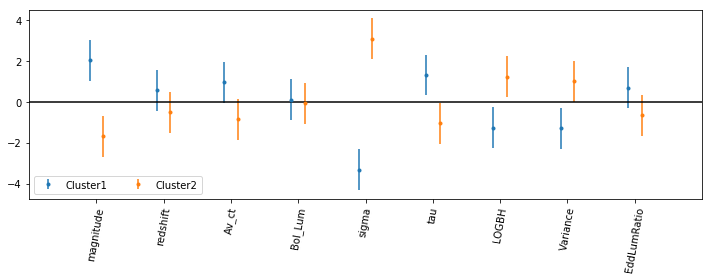

In [251]:
plt.figure(figsize=(10, 4))
ind = np.arange(0, len(feat_list), 1, dtype='int')
plt.errorbar(ind-0.1, (feats_mean[:,0]-1)/feats_std[:,0], yerr=1,  fmt='.', label='Cluster1')
plt.errorbar(ind+0.1, (feats_mean[:,1]-1)/feats_std[:,1], yerr=1, fmt='.', label='Cluster2')
#plt.errorbar(ind, (feats_mean[:,2]-1)/feats_std[:,2], yerr=1, fmt='.', label='Center')
plt.hlines(0, -10, 10)
plt.xlim(-1, 9)
plt.xticks(ind, feat_list, rotation=80)
plt.legend(loc='lower left', ncol=4)
plt.tight_layout()
plt.show()

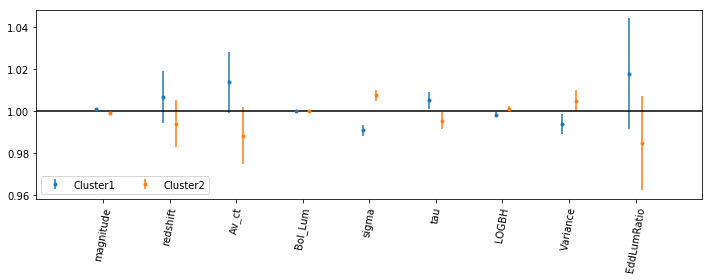

In [250]:
plt.figure(figsize=(10, 4))
ind = np.arange(0, len(feat_list), 1, dtype='int')
plt.errorbar(ind-0.1, feats_mean[:,0], yerr=feats_std[:,0], fmt='.', label='Cluster1')
plt.errorbar(ind+0.1, feats_mean[:,1], yerr=feats_std[:,1], fmt='.', label='Cluster2')
#plt.errorbar(ind+0.05, feats_mean[:,2], yerr=feats_std[:,2], fmt='.', label='Cluster3')
#plt.errorbar(ind+0.1, feats_mean[:,3], yerr=feats_std[:,3], fmt='.', label='Cluster3')
plt.hlines(1, -10, 10)
plt.xlim(-1, 9)
plt.xticks(ind, feat_list, rotation=80)
plt.legend(loc='lower left', ncol=3)
plt.tight_layout()
plt.show()

In [122]:
import subprocess 

In [511]:
PPP_w_cmd = 'ls ./PPP/PPP_181022_EddLumRatio/weights_epoch_*.h5'
PPP_w_list = np.array(subprocess.check_output(PPP_w_cmd, shell=True).decode('utf-8').split('\n')[:-1])

In [512]:
epoch = np.array([int(PPP_w.split('/')[-1].split('.')[0].split('_')[-1]) for PPP_w in PPP_w_list])

In [513]:
PPP_w_ind = np.argsort(epoch)

In [514]:
PPP_w_list = PPP_w_list[PPP_w_ind]
epoch = epoch[PPP_w_ind]

In [148]:
from keras.layers import  LSTM, GRU, Input
from keras.models import Model
import pandas as pd
import numpy as np
from sklearn.utils import resample
from keras.layers import Input, Dense, Dropout, BatchNormalization

In [515]:
main_input = Input(shape=[len(encoding[0])], name='features')
model = Dense(128, activation='selu', use_bias=True, bias_initializer='zeros')(main_input)
model = Dropout(0.5)(model)
model = Dense(128, activation='selu', use_bias=True, bias_initializer='zeros')(model)
model = Dropout(0.5)(model)
model = Dense(1, activation='linear', use_bias=True, bias_initializer='zeros')(model)
reg_model = Model(main_input, model)

json_string = reg_model.to_json()
open('PPP_model.json', 'w').write(json_string)

2345

In [29]:
PPP_model_json = './PPP/PPP_181022_EddLumRatio/PPP_model.json'
json_string = open(PPP_model_json).read()
PPP_model = model_from_json(json_string)

In [525]:
PPP_model.load_weights(PPP_w_list[-1])

In [526]:
qso_t_features = np.loadtxt('./feats_epoch/%d_t.dat'%epoch[-1], dtype='str')
qso_v_features = np.loadtxt('./feats_epoch/%d_v.dat'%epoch[-1], dtype='str')

In [527]:
qso_train_list = qso_t_features[:,0]
qso_valid_list = qso_v_features[:,0]
qso_t_features = np.array(qso_t_features[:,1:], dtype='float')
qso_v_features = np.array(qso_v_features[:,1:], dtype='float')

In [539]:
EddLumRatio_t_arr = np.empty(len(qso_train_list))
EddLumRatio_v_arr = np.empty(len(qso_valid_list))
Variance_t_arr = np.empty(len(qso_train_list))
Variance_v_arr = np.empty(len(qso_valid_list))

for i, crts_id in enumerate(qso_train_list):
    crts_id = int(crts_id.replace('.dat', ''))
    EddLumRatio_t_arr[i] = cat.EddLumRatio[cat.CRTS_id == crts_id]
    Variance_t_arr[i] = cat.Variance[cat.CRTS_id == crts_id]
for i, crts_id in enumerate(qso_valid_list):
    crts_id = int(crts_id.replace('.dat', ''))
    EddLumRatio_v_arr[i] = cat.EddLumRatio[cat.CRTS_id == crts_id]
    Variance_v_arr[i] = cat.Variance[cat.CRTS_id == crts_id]

In [36]:
def norm_feat(feat):
    feat[np.isinf(feat)] = np.nan
    median = np.nanmedian(feat)
    std_arr = np.nanpercentile(feat, [18, 82])
    std = np.abs(std_arr[0] - std_arr[1])/2
    return (feat-median)/std

In [540]:
mask_t = (EddLumRatio_t_arr > 0) & (EddLumRatio_t_arr < 1) & (~np.isnan(EddLumRatio_t_arr)) & (~np.isinf(EddLumRatio_t_arr))
mask_v = (EddLumRatio_v_arr > 0) & (EddLumRatio_v_arr < 1) & (~np.isnan(EddLumRatio_v_arr)) & (~np.isinf(EddLumRatio_v_arr))

In [542]:
np.nanpercentile(EddLumRatio_t_arr[mask_t], [1, 99]), np.nanpercentile(EddLumRatio_v_arr[mask_v], [1, 99])

(array([0.00630202, 0.65795243]), array([0.00731174, 0.60062522]))

In [543]:
Edd_lum_t_norm = norm_feat(EddLumRatio_t_arr[mask_t])
Edd_lum_v_norm = norm_feat(EddLumRatio_v_arr[mask_v])
Variance_t_norm = norm_feat(Variance_t_arr[mask_t])
Variance_v_norm = norm_feat(Variance_v_arr[mask_v])

In [544]:
NoInfo_t = np.random.randn(len(Edd_lum_t_norm))
NoInfo_v = np.random.randn(len(Edd_lum_t_norm))

In [545]:
input_t = qso_t_features[mask_t]
input_v = qso_v_features[mask_v]
output_t = Edd_lum_t_norm[:,np.newaxis]
output_v = Edd_lum_v_norm[:,np.newaxis]
var_t = Variance_t_norm[:,np.newaxis]
var_v = Variance_v_norm[:,np.newaxis]

In [546]:
input_all = np.r_[input_t, input_v]
output_all = np.r_[output_t, output_v]
noinfo_all = np.r_[NoInfo_t, NoInfo_v]
var_all = np.r_[var_t, var_v]

In [547]:
pred_all = PPP_model.predict(input_all)

In [548]:
r_xy = np.corrcoef(np.squeeze(pred_all), np.squeeze(output_all))[0,1]
r_xy

0.32485372390783773

In [549]:
r_xz = np.corrcoef(np.squeeze(pred_all), np.squeeze(var_all))[0,1]
r_xz

-0.41860143899313634

In [550]:
r_yz = np.corrcoef(np.squeeze(output_all), np.squeeze(var_all))[0,1]
r_yz

-0.23469173750098987

In [551]:
def pcorrcoef(x, y, z):
    r_xy = np.corrcoef(np.squeeze(x), np.squeeze(y))[0,1]
    r_xz = np.corrcoef(np.squeeze(x), np.squeeze(z))[0,1]
    r_yz = np.corrcoef(np.squeeze(y), np.squeeze(z))[0,1]
    return (r_xy - r_xz*r_yz)/np.sqrt(1-r_xz**2)/np.sqrt(1-r_yz**2)

In [552]:
pcorrcoef(np.squeeze(pred_all), np.squeeze(output_all), np.squeeze(var_all))

0.2566948497666618

(-3, 2)

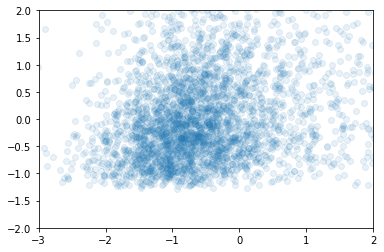

In [553]:
plt.scatter(np.squeeze(pred_all), np.squeeze(output_all), alpha=0.1)
plt.ylim(-2, 2)
plt.xlim(-3, 2)
#plt.yscale('log')

In [554]:
feats_ind = np.arange(0, len(input_all), 1, dtype=int)

In [555]:
Nboot = 10000
NoInfo_Cor_boot = np.empty(Nboot)
NoInfo_pCor_boot = np.empty(Nboot)
for i in range(Nboot):
    random_ind = np.random.choice(feats_ind, len(feats_ind), replace=True)
    Noinfo_boot = noinfo_all[random_ind]
    output_boot = output_all[random_ind]
    var_boot = var_all[random_ind]
    NoInfo_Cor_boot[i] = np.corrcoef(Noinfo_boot, np.squeeze(output_boot))[0,1]
    NoInfo_pCor_boot[i] = pcorrcoef(Noinfo_boot, np.squeeze(output_boot), np.squeeze(var_boot))
NoInfo_Cor = np.mean(NoInfo_Cor_boot)
NoInfo_Cor_std = np.std(NoInfo_Cor_boot)
NoInfo_pCor = np.mean(NoInfo_pCor_boot)
NoInfo_pCor_std = np.std(NoInfo_pCor_boot)

In [244]:
Nboot = 10000
BolLum_Cor_boot = np.empty(Nboot)
for i in range(Nboot):
    random_ind = np.random.choice(feats_ind, len(feats_ind), replace=True)
    pred_boot = pred_all[random_ind]
    output_boot = output_all[random_ind]
    BolLum_Cor_boot[i] = np.corrcoef(np.squeeze(pred_boot), np.squeeze(output_boot))[0,1]
BolLum_Cor = np.mean(BolLum_Cor_boot)
BolLum_Cor_std = np.std(BolLum_Cor_boot)

In [556]:
Nboot = 10000
BolLum_Cor = np.empty(len(epoch))
BolLum_Cor_std = np.empty(len(epoch))
BolLum_pCor = np.empty(len(epoch))
BolLum_pCor_std = np.empty(len(epoch))

for i, (e, w) in enumerate(zip(epoch, PPP_w_list)):
    print(w)
    qso_t_features = np.loadtxt('./feats_epoch/%d_t.dat'%e, dtype='str')
    qso_v_features = np.loadtxt('./feats_epoch/%d_v.dat'%e, dtype='str')
    qso_t_features = np.array(qso_t_features[:,1:], dtype='float')
    qso_v_features = np.array(qso_v_features[:,1:], dtype='float')
    input_t = qso_t_features[mask_t]
    input_v = qso_v_features[mask_v]
    input_all = np.r_[input_t, input_v]
    PPP_model.load_weights(w)
    pred_all = PPP_model.predict(input_all)

    BolLum_Cor_boot = np.empty(Nboot)
    BolLum_pCor_boot = np.empty(Nboot)
    for j in range(Nboot):
        random_ind = np.random.choice(feats_ind, len(feats_ind), replace=True)
        pred_boot = pred_all[random_ind]
        output_boot = output_all[random_ind]
        var_boot = var_all[random_ind]
        BolLum_Cor_boot[j] = np.corrcoef(np.squeeze(pred_boot), np.squeeze(output_boot))[0,1]
        BolLum_pCor_boot[j] = pcorrcoef(np.squeeze(pred_boot), np.squeeze(output_boot), np.squeeze(var_boot))
    BolLum_Cor[i] = np.mean(BolLum_Cor_boot)
    BolLum_Cor_std[i] = np.std(BolLum_Cor_boot)
    BolLum_pCor[i] = np.mean(BolLum_pCor_boot)
    BolLum_pCor_std[i] = np.std(BolLum_pCor_boot)   

./PPP/PPP_181022_EddLumRatio/weights_epoch_10.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_110.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_210.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_310.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_410.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_510.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_610.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_710.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_810.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_910.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1010.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1110.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1210.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1310.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1410.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1510.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1610.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1710.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch_1810.h5
./PPP/PPP_181022_EddLumRatio/weights_epoch

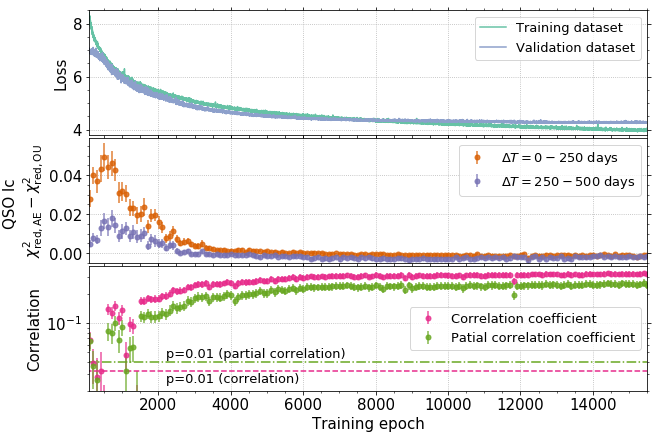

In [666]:
xlims = [90, 15500]
gs = grs.GridSpec(3, 1, height_ratios=(1,1,1))
plt.figure(figsize=(10, 7))
plt.subplots_adjust(hspace=0.025)
ax = []
loc=9710
for ind in range(3):
    ax.append(plt.subplot(gs[ind]))
    
ax[0].tick_params(which="both", top=True, right=True, labelsize = 15, labelbottom="off", labeltop='off')
ax[0].grid(ls='dotted', zorder=2)
ax[0].minorticks_on()
ax[0].errorbar(train_log.epoch, train_log.loss, 
               color='#66c2a5', label='Training dataset')
ax[0].errorbar(train_log.epoch, train_log.val_loss, 
               color='#8da0cb', label='Validation dataset')
#ax[0].vlines(loc, -10, 10)
#ax[0].text(loc*1.01, 7.5, 'Epoch = %i'%loc , rotation=90, fontsize=13)
#ax[0].set_xscale('log')
ax[0].set_xlim(xlims); ax[0].set_ylim(3.8, 8.5)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend(loc='upper right', fontsize=13)

ax[1].tick_params(which="both", top=True, right=True, labelsize = 15, labelbottom="off", labeltop='off')
ax[1].grid(ls='dotted', zorder=2)
ax[1].minorticks_on()
ax[1].errorbar(redchisq['w_epochs'], redchisq['qso_mean'][:,7], yerr=redchisq['qso_std'][:,7], 
             fmt='.', color='#d95f02', alpha=0.8, label=r'$\Delta T = 0 - 250$ days', ms=10)
ax[1].errorbar(redchisq['w_epochs'], redchisq['qso_mean'][:,8], yerr=redchisq['qso_std'][:,8], 
             fmt='.', color='#7570b3', alpha=0.8, label=r'$\Delta T = 250 - 500$ days', ms=10)
#ax[1].vlines(loc, -10, 10)
#ax[1].set_xscale('log')
ax[1].set_xlim(xlims); ax[1].set_ylim(-0.005, 0.059)
ax[1].set_ylabel(r"""QSO lc 
$\chi_{\mathrm{red, AE}}^2 - \chi_{\mathrm{red, OU}}^2$""", fontsize=15)
ax[1].legend(loc='upper right', fontsize=13)


ax[2].tick_params(which="both", top=True, right=True, labelsize = 15)
ax[2].grid(ls='dotted', zorder=2)
ax[2].minorticks_on()
ax[2].errorbar(epoch, np.abs(BolLum_Cor), yerr=BolLum_Cor_std, 
             fmt='.', color='#e7298a', alpha=0.8, label='Correlation coefficient', ms=10)
ax[2].errorbar(epoch, np.abs(BolLum_pCor), yerr=BolLum_pCor_std, 
             fmt='.', color='#66a61e', alpha=0.8, label='Patial correlation coefficient', ms=10)
ax[2].hlines(NoInfo_Cor+NoInfo_Cor_std*2.33/2, 0, 100000, linestyle='--', color='#e7298a')
ax[2].hlines(NoInfo_pCor+NoInfo_pCor_std*2.33/2, 0, 100000, linestyle='-.', color='#66a61e')

ax[2].text(2200, (NoInfo_pCor+NoInfo_pCor_std*2.33/2)*1.1, 
           'p=0.01 (partial correlation)',  fontsize=13)

ax[2].text(2200, (NoInfo_Cor+NoInfo_Cor_std*2.33/2)/1.3, 
           'p=0.01 (correlation)',  fontsize=13)

#ax[2].vlines(loc, -10, 10)
ax[2].set_yscale('log')
ax[2].set_xlim(xlims); ax[2].set_ylim(2e-2, 0.39)
ax[2].set_xlabel('Training epoch', fontsize=15)
ax[2].set_ylabel('Correlation', fontsize=15)
ax[2].legend(loc='center right', fontsize=13)

plt.savefig('Loss_CorrCoef_epoch.pdf')

plt.show()

In [27]:
def cov2corr(cov):
    D=np.diag(np.power(np.diag(cov),-0.5))
    corr=np.dot(np.dot(D,cov),D)
    return corr
def cov2partialcorr(cov):
    omega=np.linalg.inv(cov)
     
    D=np.diag(np.power(np.diag(omega),-0.5))
    partialcorr=-np.dot(np.dot(D,omega),D)
    partialcorr+=2*np.eye(cov.shape[0])
    return partialcorr

In [30]:
qso_t_features = np.loadtxt('./feats_epoch/9710_t.dat', dtype='str')
qso_v_features = np.loadtxt('./feats_epoch/9710_v.dat', dtype='str')
qso_train_list = qso_t_features[:,0]
qso_valid_list = qso_v_features[:,0]
qso_t_features = np.array(qso_t_features[:,1:], dtype='float')
qso_v_features = np.array(qso_v_features[:,1:], dtype='float')
input_t = qso_t_features
input_v = qso_v_features
input_all = np.r_[input_t, input_v]
qso_list = np.r_[qso_train_list, qso_valid_list]
PPP_model.load_weights('./PPP/PPP_181022_EddLumRatio/weights_epoch_9710.h5')
pred_all = PPP_model.predict(input_all)

In [31]:
cat = pd.read_csv('../../../../Catalogs/CRTS_QSO_catalog_slope.csv')

In [32]:
Bol_lum_arr = np.empty(len(qso_list))
EddLumRatio_arr = np.empty(len(qso_list))
redshift_arr = np.empty(len(qso_list))
mag_arr = np.empty(len(qso_list))
var_arr = np.empty(len(qso_list))
slope_arr = np.empty(len(qso_list))
Av_arr = np.empty(len(qso_list))
sigma_arr = np.empty(len(qso_list))
tau_arr = np.empty(len(qso_list))
Mbh_arr = np.empty(len(qso_list))

for i, crts_id in enumerate(qso_list):
    crts_id = int(crts_id.replace('.dat', ''))
    Bol_lum_arr[i] = np.log10(cat.Bol_Lum[cat.CRTS_id == crts_id])
    redshift_arr[i] = np.log10(cat.redshift[cat.CRTS_id == crts_id])
    mag_arr[i] = cat.MeanMag[cat.CRTS_id == crts_id]
    var_arr[i] = np.log10(cat.Variance[cat.CRTS_id == crts_id])
    slope_arr[i] = cat.slope[cat.CRTS_id == crts_id]
    Av_arr[i] = cat.Av_ct[cat.CRTS_id == crts_id]
    sigma_arr[i] = np.log10(cat.sigma[cat.CRTS_id == crts_id]**2)
    tau_arr[i] = np.log10(cat.tau[cat.CRTS_id == crts_id])
    EddLumRatio_arr[i] = cat.EddLumRatio[cat.CRTS_id == crts_id]
    Mbh_arr[i] = cat.LOGBH[cat.CRTS_id == crts_id]

In [33]:
mask = (EddLumRatio_arr > 0) & (EddLumRatio_arr < 1) & (~np.isnan(EddLumRatio_arr)) & (~np.isinf(EddLumRatio_arr)) & (~np.isnan(var_arr))

In [37]:
Edd_lum_norm = norm_feat(EddLumRatio_arr[mask])
Bol_lum_norm = norm_feat(Bol_lum_arr[mask])
redshift_norm = norm_feat(redshift_arr[mask])
mag_norm = norm_feat(mag_arr[mask])
var_norm = norm_feat(var_arr[mask])
slope_norm = norm_feat(slope_arr[mask])
Av_norm = norm_feat(Av_arr[mask])
sigma_norm = norm_feat(sigma_arr[mask])
tau_norm = norm_feat(tau_arr[mask])
Mbh_norm = norm_feat(Mbh_arr[mask])
pred_norm = norm_feat(pred_all[mask])

NoInfo = np.random.randn(len(Bol_lum_norm))
NoInfo2 = np.random.rand(len(Bol_lum_norm))

In [726]:
features = pd.DataFrame({
                          r'M$_{\mathrm{BH}}$': Mbh_norm, 
                          'RedShift': redshift_norm, 
                          'Magnitude': mag_norm, 
                          #'Variance': var_norm, 
                          #'Sigma': sigma_norm, 
                          #'Tau': tau_norm, 
                          'Extinction': Av_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})

In [727]:
feature_names = features.columns

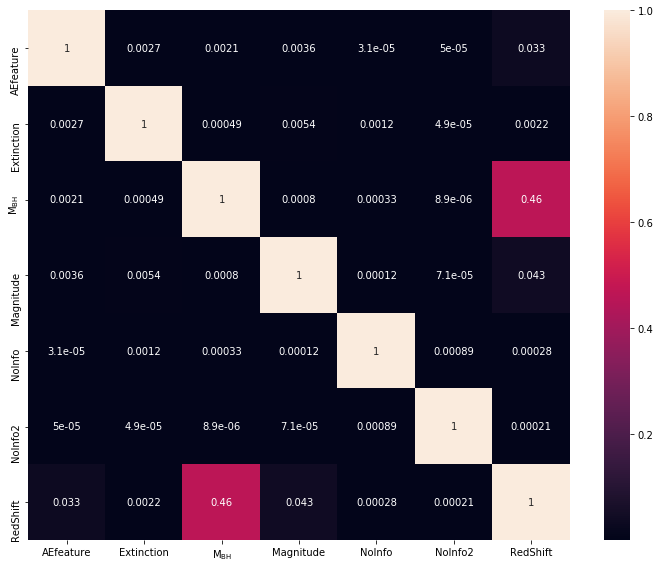

In [728]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2corr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

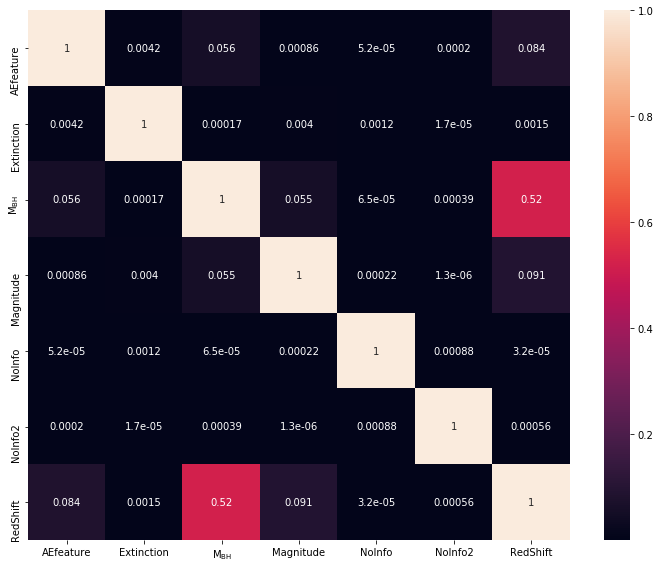

In [729]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

In [730]:
features_arr =  np.array(features).T

In [731]:
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')
Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[0]

In [732]:
PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

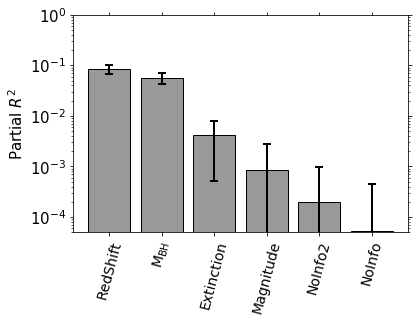

In [733]:
Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_physical_AEfeatures.pdf')


In [734]:
features = pd.DataFrame({
                          'EddLum': Edd_lum_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns

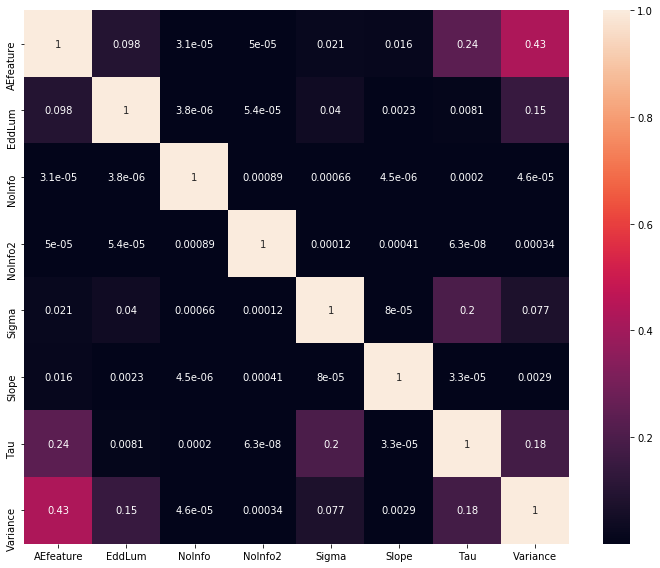

In [735]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2corr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

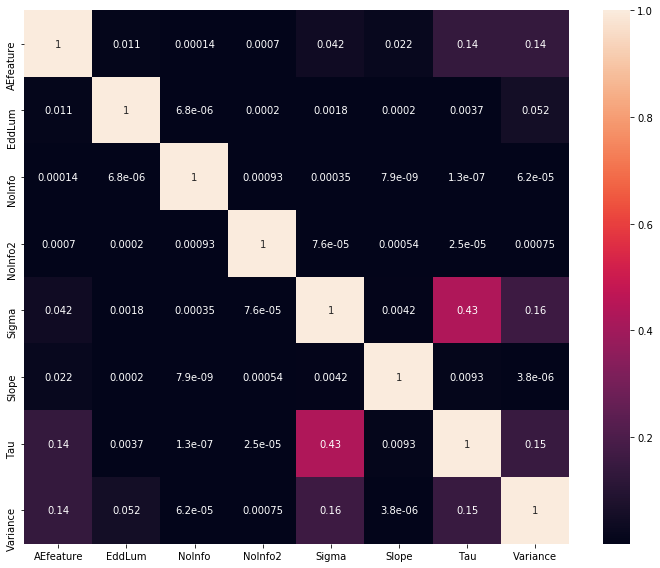

In [736]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

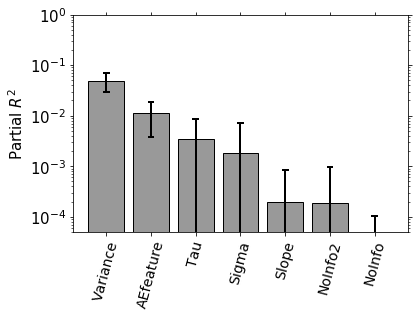

In [737]:
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')
Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[1]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_Ledd.pdf')


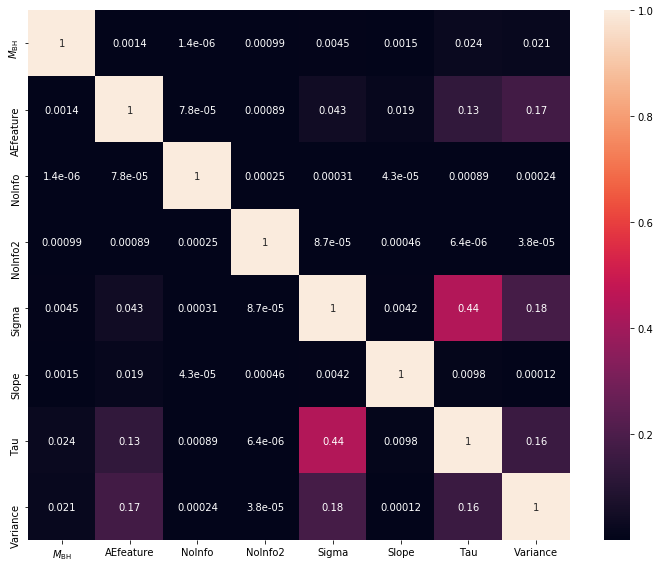

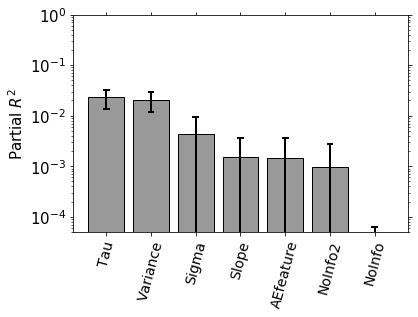

In [46]:
features = pd.DataFrame({
                          r'$M_\mathrm{BH}$': Mbh_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')

plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

plt.show()

Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[0]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_MBH.pdf')


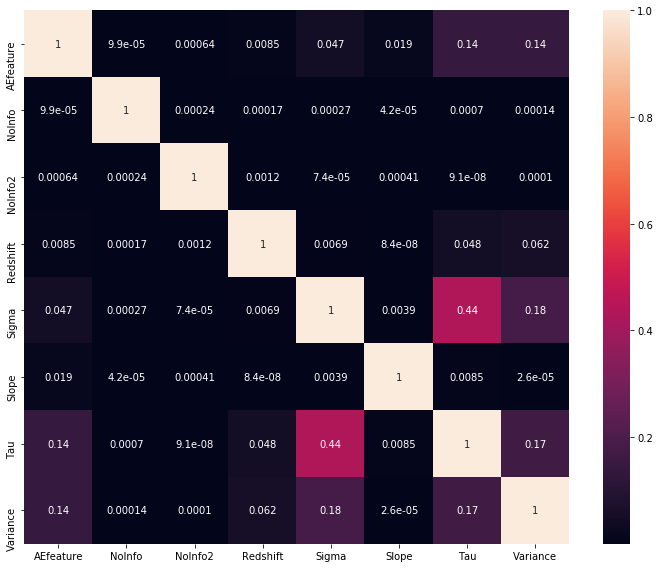

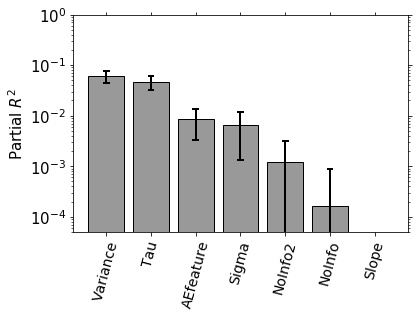

In [48]:
features = pd.DataFrame({
                          r'Redshift': redshift_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')

plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

plt.show()

Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[3]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_redshift.pdf')

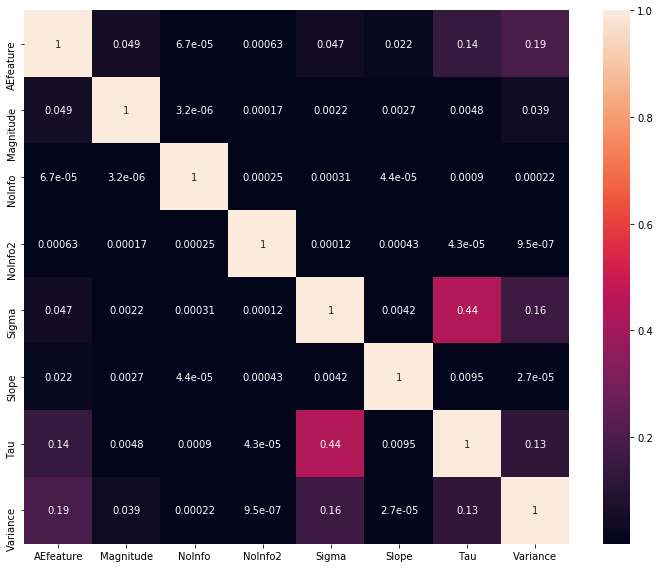

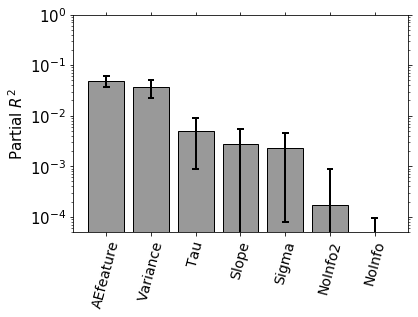

In [50]:
features = pd.DataFrame({
                          'Magnitude': mag_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')

plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

plt.show()

Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[1]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_magitude.pdf')

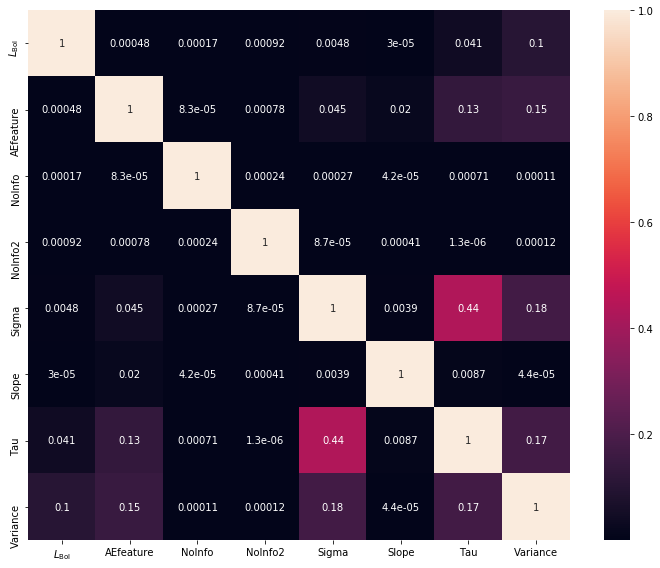

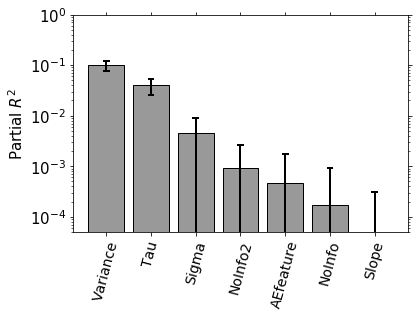

In [53]:
features = pd.DataFrame({
                          r'$L_\mathrm{Bol}$': Bol_lum_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')

plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

plt.show()

Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[0]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_Lbol.pdf')

In [ ]:
features = pd.DataFrame({
                          'Extinction': Av_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')
Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[1]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')
plt.savefig('pCorrCoef_timeseries_redshift.pdf')

In [738]:
features = pd.DataFrame({
                          #'Mbh': Mbh_norm,
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns

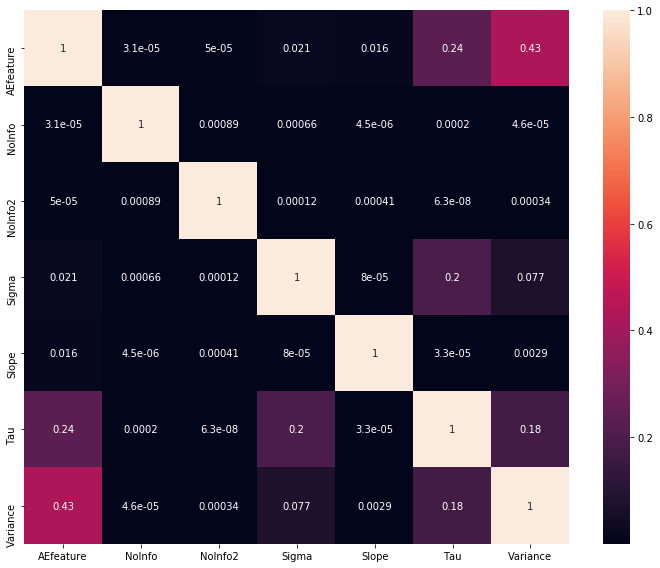

In [739]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2corr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

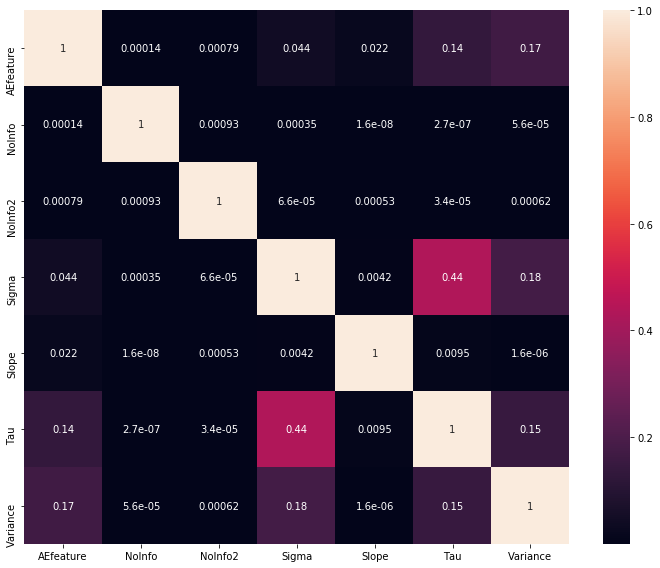

In [740]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov2partialcorr(np.cov(np.array(features).T))**2, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)
plt.tight_layout()

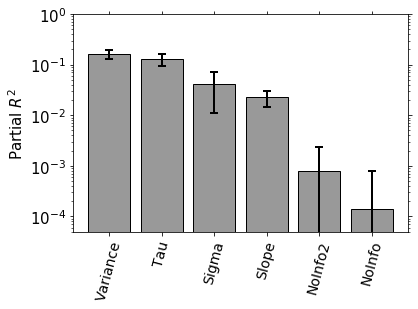

In [741]:
features_arr =  np.array(features).T
ind_list = np.arange(0, len(np.squeeze(pred_norm)), 1, dtype='int')
Nboot = 10000
PCor_boot = np.empty((len(features.columns), Nboot))
for i in range(Nboot):
    random_ind = np.random.choice(ind_list, len(ind_list), replace=True)
    features_boot = features_arr[:,random_ind]
    PCor_boot[:,i] = cov2partialcorr(np.cov(features_boot))[0]

PCor = np.mean(PCor_boot, axis=1)
PCor_std = np.std(PCor_boot, axis=1)

PR2 = PCor**2
PR2_68_interval = 2*PCor*PCor_std*1.645

Index = np.arange(1, len(feature_names), 1)
order = np.argsort(PR2)[::-1][1:]
ewidth = 0.075

plt.bar(Index, PR2[order], color='0.6', edgecolor='k', linewidth=1)
#plt.errorbar(Index, BolLum_R2[order], BolLum_R2_90_interval[order], fmt='.', color='k', markersize=20)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.vlines(Index, PR2[order] -  PR2_68_interval[order], 
           PR2[order] +  PR2_68_interval[order], 
          linewidth=2)
plt.hlines(PR2[order] -  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.hlines(PR2[order]+  PR2_68_interval[order], Index - ewidth, Index + ewidth, linewidth=2)
plt.tick_params(which="both", top=True, right=True)
plt.tick_params(labelsize = 15)
plt.ylabel(r'Partial $R^2$', fontsize=15)
plt.ylim(5e-5, 1)
plt.xticks(Index, feature_names[order], color='k', fontsize=14, rotation=75)
plt.yscale('log')

plt.savefig('pCorrCoef_timeseries_AEfeatures.pdf')


In [8]:
tau  = cat.tau.values
sigma = cat.sigma.values

In [745]:
sigma

array([0.0256269 , 0.00607289, 0.01351748, ..., 0.0373271 , 0.03718802,
       0.03113486])

In [9]:
par_mask = (tau > 0.1) & (tau < 10000) & (sigma**2 > 1e-7) & (sigma**2 < 1e-2)

In [843]:
rx,  ry, rz  =  kde_contour_dat(np.log10(sigma**2)[par_mask], np.log10(tau)[par_mask], grid_bins=500, extent=[-7, 2, -1, 4])

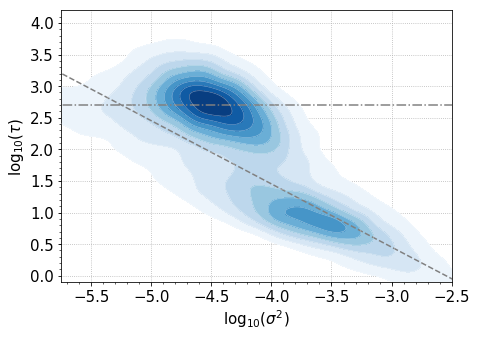

In [862]:
plt.figure(figsize=(7,5))
plt.minorticks_on()
plt.grid(ls=':', zorder=1)
plt.tick_params(labelsize = 15)
plt.contourf(rx, ry, rz, levels = levels, cmap='Blues', zorder=2)
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 3)
x = 10**np.arange(-10, 10, 5.)
plt.plot(np.log10(x), np.log10(2*(np.mean(err))**2/x), linestyle='--', color='0.5')
plt.plot(np.log10(x), np.log10(np.mean(cat.ObsLength.values)/10)*np.ones_like(x), linestyle='-.', color='0.5')
plt.xlabel(r'$\log_{10}(\sigma^2)$', fontsize=15)
plt.ylabel(r'$\log_{10}(\tau)$', fontsize=15)
plt.xlim(-5.75, -2.5)
plt.ylim(-0.1, 4.2)
plt.savefig('OU_par.pdf')

In [11]:
nan_mask = (~np.isnan(cat.Bol_Lum.values)) & (~np.isnan(cat.Variance.values)) & (cat.Variance.values>0) & \
            (1e40< cat.Bol_Lum.values) & (cat.Bol_Lum.values < 1e50)


In [12]:
cat = pd.read_csv('../../../../Catalogs/CRTS_QSO_catalog_slope.csv')

In [13]:
lbol  = np.log10(cat.Bol_Lum.values[par_mask&nan_mask])
vari = np.log10(cat.Variance.values[par_mask&nan_mask])

In [15]:
rxv,  ryv, rzv  =  kde_contour_dat(lbol, vari, grid_bins=100, extent=[43, 47.5, -4, -1])

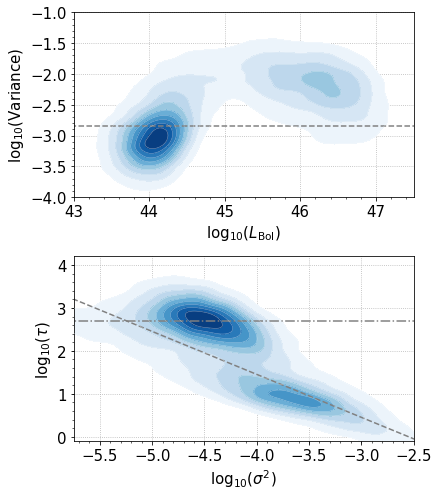

In [906]:
plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.minorticks_on()
plt.grid(ls=':', zorder=1)
plt.tick_params(labelsize = 15)
plt.contourf(rxv, ryv, rzv, levels = levels, cmap='Blues', zorder=2)
plt.contour(rxv, ryv, rzv, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 3)
x = 10**np.arange(40, 100, 10.)
plt.plot(np.log10(x), np.log10(np.mean(err)**2*np.ones_like(x)), linestyle='--', color='0.5')
plt.xlabel(r'$\log_{10}(L_{\mathrm{Bol}})$', fontsize=15)
plt.ylabel(r'$\log_{10}(\mathrm{Variance})$', fontsize=15)
plt.xlim(43, 47.5)
plt.ylim(-4, -1)

plt.subplot(2,1,2)
plt.minorticks_on()
plt.grid(ls=':', zorder=1)
plt.tick_params(labelsize = 15)
plt.contourf(rx, ry, rz, levels = levels, cmap='Blues', zorder=2)
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 3)
x = 10**np.arange(-10, 10, 5.)
plt.plot(np.log10(x), np.log10(2*(np.mean(err))**2/x), linestyle='--', color='0.5')
plt.plot(np.log10(x), np.log10(np.mean(cat.ObsLength.values)/10)*np.ones_like(x), linestyle='-.', color='0.5')
plt.xlabel(r'$\log_{10}(\sigma^2)$', fontsize=15)
plt.ylabel(r'$\log_{10}(\tau)$', fontsize=15)
plt.xlim(-5.75, -2.5)
plt.ylim(-0.1, 4.2)

plt.tight_layout()
plt.savefig('OU_par_var_lbol.pdf')


In [16]:
meandelT = cat.MeanDeltaT[par_mask&nan_mask]
maddelT = cat.MedDeltaT[par_mask&nan_mask]

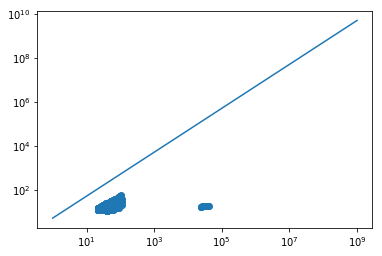

In [21]:
plt.scatter(meandelT, maddelT)
plt.plot(10**np.arange(0, 10, 1.), 5*10**np.arange(0, 10, 1.))
plt.yscale('log')
plt.xscale('log')

In [23]:
np.percentile(meandelT/maddelT, [1, 100])

array([1.69382483e+00, 2.23169486e+03])

In [26]:
np.percentile(cat.ObsLength, [1, 99.9])

array([2927., 4040.])

In [ ]:
lbol  = np.log10(cat.Bol_Lum.values[par_mask&nan_mask])
vari = np.log10(cat.Variance.values[par_mask&nan_mask])

In [913]:
features = pd.DataFrame({
                          'EddLum': Edd_lum_norm, 
                          'BolLum': Bol_lum_norm, 
                          'Variance': var_norm, 
                          'Slope': slope_norm, 
                          'Sigma': sigma_norm, 
                          'Tau': tau_norm, 
                          'AEfeature': np.squeeze(pred_norm), 
                          'NoInfo': NoInfo, 
                          'NoInfo2': NoInfo2})
feature_names = features.columns

In [915]:
features[0:3]

,AEfeature,BolLum,EddLum,NoInfo,NoInfo2,Sigma,Slope,Tau,Variance
0,0.533547,0.441994,0.088018,0.746558,0.046868,0.081945,-0.394895,-1.077874,-1.054074
1,1.439542,0.423427,2.427879,-1.514245,0.680399,-2.077839,1.611095,2.314299,0.389152
2,1.070670,0.502032,-0.143070,0.748726,0.561309,0.483706,-2.737508,0.980104,1.599754


In [919]:
np.corrcoef(features.AEfeature.values, features.BolLum.values)[0,1], np.corrcoef(features.Variance.values, features.BolLum.values)[0,1]

(-0.1708897735949323, -0.327183422376397)

In [924]:
np.corrcoef(features.AEfeature.values, features.EddLum.values)[0,1], np.corrcoef(features.Variance.values, features.EddLum.values)[0,1]

(-0.31237930219233856, -0.3842803090322955)

In [953]:
levels

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [945]:
rxAE,  ryAE, rzAE  =  kde_contour_dat(EddLumRatio_arr[mask], np.squeeze(pred_all[mask]), grid_bins=100, extent=[0, 0.5, -2, 4])

In [959]:
x = EddLumRatio_arr[mask]; y = np.squeeze(pred_all[mask])

In [962]:
ind_x = np.argsort(x)
x = x[ind_x]
y = y[ind_x]

In [963]:
Numbin = 100

In [967]:
len(x)

3493

In [966]:
len(x)//Numbin

34

In [1019]:
Numbin = 100
x_bin = np.empty(len(x)//Numbin+1)
y_bin_std = np.empty(len(x)//Numbin+1)
y_bin = np.empty(len(x)//Numbin+1)
x_bin_min = np.empty(len(x)//Numbin+1)
x_bin_max = np.empty(len(x)//Numbin+1)
for i, (ind_st, ind_en) in enumerate(zip(np.arange(0, len(x)//Numbin+1, 1)*Numbin, np.arange(1, len(x)//Numbin+2, 1)*Numbin)):
    if ind_en>=len(x):
        ind_en = len(x)-1
    x_bin[i] = np.mean(x[ind_st:ind_en])
    #x_bin_std[i] = np.std(x[ind_st:ind_en])/np.sqrt(len(x[ind_st:ind_en]))
    y_bin[i] = np.mean(y[ind_st:ind_en])
    y_bin_std[i] = np.std(y[ind_st:ind_en])/np.sqrt(len(y[ind_st:ind_en]))
    x_bin_min[i] = np.min(x[ind_st:ind_en])
    x_bin_max[i] = np.max(x[ind_st:ind_en])

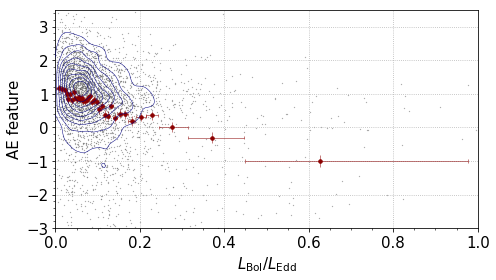

In [1021]:
plt.figure(figsize=(7, 4))
plt.minorticks_on()
plt.grid(ls=':', zorder=1)
plt.tick_params(labelsize = 15)
plt.scatter(EddLumRatio_arr[mask], pred_all[mask], marker='.', s=0.2, color='0.4')
plt.contour(rxAE, ryAE, rzAE, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("navy",), alpha = 1, zorder = 3)
plt.errorbar(x_bin, y_bin,  yerr=y_bin_std, fmt='.', color='darkred', markersize=7, linewidth=0.5)
plt.hlines(y_bin, x_bin_min, x_bin_max, color='darkred', linewidth=0.5)
plt.vlines(x_bin_min, y_bin-0.05, y_bin+0.05, color='darkred', linewidth=0.5)
plt.vlines(x_bin_max, y_bin-0.05, y_bin+0.05, color='darkred', linewidth=0.5)
plt.xlim(0, 1)
plt.ylim(-3, 3.5)
#plt.xscale('log')
plt.xlabel(r'$L_{\mathrm{Bol}}/L_{\mathrm{Edd}}$', fontsize=15)
plt.ylabel('AE feature', fontsize=15)
plt.tight_layout()
plt.savefig('AE_Eddrate.pdf')

<ErrorbarContainer object of 3 artists>

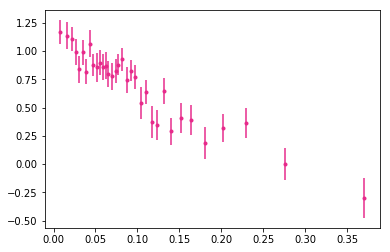

In [975]:
plt.errorbar(x_bin, y_bin,  yerr=y_bin_std, fmt='.', color='#e7298a')

In [ ]:
np.corrcoef(features.AEfeature.values, features.EddLum.values)[0,1], np.corrcoef(features.Variance.values, features.EddLum.values)[0,1]

In [912]:
1/np.median(err)

27.300892087649984

In [909]:
np.median(cat.ObsLength.values)

3974.0

In [911]:
len(X)

15438

(0.1, 10000.0)

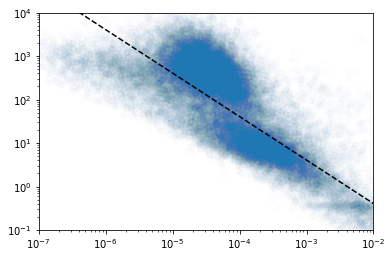

In [815]:
plt.scatter(sigma[par_mask]**2, tau[par_mask], alpha=0.01)
x = 10**np.arange(-10, 10, 1.)
plt.plot(x, 2*0.045**2/x, linestyle='--', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-7, 1e-2)
plt.ylim(1e-1, 1e4)

(0.1, 10000.0)

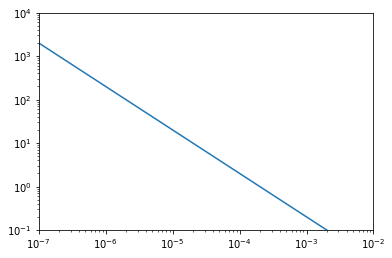

In [766]:
x = 10**np.arange(-10, 10, 1.)
plt.plot(x, 2*0.01**2/x)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-7, 1e-2)
plt.ylim(1e-1, 1e4)

In [793]:
err = []
for i in range(len(X_train)):
    err.extend(X_train[i][:,2])

In [797]:
np.median(err)

0.03662883970199519

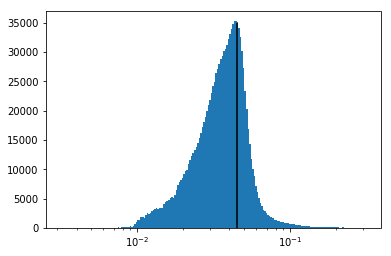

In [810]:
plt.hist(err, bins=10**np.arange(-2.5, -0.5, 0.01))
plt.vlines(0.045, 0, 35000)
plt.xscale('log')
plt.show()

In [848]:
np.median(cat.ObsLength.values)

3974.0